# FYP: Exploratory Data Analysis for HubSpot Data
**FYP Goal:** Development of an AI/ML pipeline for pre-training a foundation model for sales

**EDA1 Goal:** Study the SA_Singapore Dataset and identify cleaning steps

**Data Source:** Using the hubspot data viewer, we extracted the data set based on the below specifications

#### Filters Employed to extract SA_Singapore.csv
- Countries: Singapore

#### Data Columns extracted from HubSpot (20)
1. ```Record ID```
2. ```Company name```
3. ```Campaign```
4. ```Ideal Customer Profile```
5. ```Company Country```
6. ```Last Activity Date```
7. ```Industry (StaffAny Official)```
8. ```Associated Contact```
9. ```Deal with Primary Company```
10. ```Child Company```
11. ```First Deal Created Date```
12. ```Billing Entities```
13. ```Last Logged Call Date```
14. ```Number of times contacted```
15. ```Associated Contact IDs```
16. ```Deal with Primary Company IDs```
17. ```Child Company IDs```
18. ```Parent Company IDs```
19. ```Associated Note IDs```
20. ```Billing Entities IDs```

#### Terminology
```Company``` is a sales prospect or customer in this EDA since StaffAny is a Business-to-Business (B2B) company. Thus it's customer base are Companies by default. This is not to be confused with ```Contact```, which are entities which StaffAny uses to get to a company

### 1. Import Libraries
First, we import the necessary Python libraries required for our analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
import re
import datetime as dt
from scipy.stats import shapiro, normaltest, anderson, zscore, chisquare
from transformers import pipeline as hf_pipeline
from pprint import pprint
from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook/Lab
tqdm.pandas()

We adjust the root of our directory correctly

In [2]:
# the root of your project, adjust according to the current path in the output
os.chdir('../')

And import the local modules we need

In [3]:
from src.api.api_token import HubSpotOAuthAPIToken
from src.api.service_factory import ServiceFactory
from src.config import HUBSPOT_OAUTH_TOKEN

As our dataset is high dimensional, we will also set the following option so we can view the full dataframe within the viewport when using head()

In [4]:
pd.set_option('display.max_columns', None)

### 2. Load the Dataset

In [5]:
# Read the Data
raw_df = pd.read_csv('data/SA_Singapore.csv')

#### View the data

In [6]:
raw_df.head()

,Record ID,Company name,Campaign,Ideal Customer Profile,Company Country,Last Activity Date,Industry (StaffAny Official),Associated Contact,Deal with Primary Company,Child Company,Parent Company,Associated Note,Churn Date,Likelihood to close,Number of Associated Contacts,First Deal Created Date,Billing Entities,Last Logged Call Date,Number of times contacted,First Contact Create Date,Is Billing Entity,Create Date,Associated Contact IDs,Deal with Primary CompanyIDs,Child CompanyIDs,Parent CompanyIDs,Associated Note IDs,Billing EntitiesIDs
0,20105797736,herohospitality.com,NaN,NaN,Singapore,2024-04-08 17:24,Services,Denson Toh Toh (denson.toh@herohospitality.com),herohospitality.com - New Deal,NaN,NaN,"service provider, F&B, deployment of staff. he...",NaN,55.51,1.0,2024-04-05 15:31,NaN,2024-04-08 16:49,5.0,2024-04-05 14:55,NaN,2024-04-05 14:55,9646931575,18442479209,NaN,NaN,50524365338;50525721635,NaN
1,19740803443,tehtarikgelek.com,NaN,NaN,Singapore,2024-04-08 18:00,Food & Beverages,nasuha darke Darke (nasuhadarke@gmail.com),tehtarikgelek.com - New Deal,NaN,NaN,NaN,NaN,40.85,1.0,2024-04-01 15:41,NaN,2024-04-01 15:36,7.0,2024-03-29 06:28,NaN,2024-03-29 06:28,40279301,18353061121,NaN,NaN,NaN,NaN
2,5217550816,Simply Wrapps,NaN,ICP3 (Owner with outlet managers),Singapore,2023-10-16 15:41,Food & Beverages,Meng Teck Wong (mengteck@simplywrapps.com);Vin...,NaN,NaN,NaN,"Vincent Tan, Koh Yong Thye and another silent ...",NaN,36.28,4.0,NaN,NaN,2023-10-16 15:37,33.0,2019-05-15 18:36,NaN,2019-05-02 16:30,3860984;257101;30291551;3771605,NaN,NaN,NaN,19302515888;41248930874;19854291633;1068641940...,NaN
3,20164869225,Big Sam Tuition Group,NaN,NaN,Singapore,2024-04-23 13:12,Services,Samuel Jeyakumar (kumar_samuel@yahoo.com),Big Sam Tuition Group - New Deal,NaN,NaN,"giro payment. 4 main staff , 1 remote social m...",NaN,34.75,1.0,2024-04-09 12:22,NaN,2024-04-23 13:12,6.0,2024-04-09 11:46,NaN,2024-04-09 11:47,10657069119,18516455954,NaN,NaN,50826920781,NaN
4,18598695835,Hiddenjoy,NaN,ICP1 (Owner with 1 outlet),Singapore,2024-01-11 08:00,Food & Beverages,Eliza (reservation@hiddenjoy.com.sg),Hiddenjoy - New Deal,NaN,NaN,1 outlet 15-20 staff (expanding) schedule - st...,NaN,34.13,1.0,2024-01-04 10:35,NaN,NaN,3.0,2024-01-03 16:21,NaN,2024-01-03 16:21,37110301,16794863729,NaN,NaN,45199236189;45209138039,NaN


A quick look at the data shows us that we have a lot of different data types available

#### Data Exploration
Employ summary statistics to understand its structure, missing values, and basic statistics.

In [7]:
raw_df.describe()

,Record ID,Likelihood to close,Number of Associated Contacts,Number of times contacted,Parent CompanyIDs
count,3.774000e+03,2617.000000,3768.000000,3393.000000,4.710000e+02
mean,8.613242e+09,3.205609,2.535563,14.742411,5.601694e+09
std,4.876633e+09,3.850246,4.095723,23.450412,3.317769e+09
min,6.376982e+08,0.180000,0.000000,0.000000,6.376982e+08
25%,5.202938e+09,1.010000,1.000000,1.000000,2.095473e+09
50%,9.003848e+09,2.040000,1.000000,7.000000,5.217540e+09
75%,1.157258e+10,4.210000,3.000000,19.000000,9.002952e+09
max,2.042355e+10,55.510000,94.000000,430.000000,1.932229e+10


Seems like there are many hidden fields where the data summary cannot be employed

Further exploration using info() function

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Record ID                      3774 non-null   int64  
 1   Company name                   3774 non-null   object 
 2   Campaign                       1261 non-null   object 
 3   Ideal Customer Profile         2276 non-null   object 
 4   Company Country                3774 non-null   object 
 5   Last Activity Date             3390 non-null   object 
 6   Industry (StaffAny Official)   3103 non-null   object 
 7   Associated Contact             3492 non-null   object 
 8   Deal with Primary Company      2651 non-null   object 
 9   Child Company                  385 non-null    object 
 10  Parent Company                 471 non-null    object 
 11  Associated Note                2000 non-null   object 
 12  Churn Date                     319 non-null    o

#### Preliminary Notes
1. IDs are mappings to the actual Objects in HubSpot
2. Some IDs are in float64 and others as object. We need to standardize this
3. BE Entities and Non-BE Enties are in the same dateset
4. Some Dates are in Objects, we needa convert them into Python Date Time Objects
5. Many other non-null variables are present, with ambiguous data types ('object')
6. Many NaN entries

### 3. Clean the Data Set
Based on the preliminary notes, we will clean the data set accordingly

In [9]:
working_df = raw_df.copy()

#### float64 to int64
Some 'float64' columns might actually be int64. We will investigate to determine if they can be all converted to int64

In [10]:
float64_to_int64_columns = [
    'Number of Associated Contacts',
    'Number of times contacted',
    'Parent CompanyIDs',
]

working_df[float64_to_int64_columns].dropna(subset=float64_to_int64_columns).head(1)

,Number of Associated Contacts,Number of times contacted,Parent CompanyIDs
8,7.0,40.0,2.087024e+09


We will now convert these columns into the 'int64' data type. Some of these entries are recorded as NaN. We will convert them to 0

In [11]:
# Fill NaN with 0 and convert to int64
for item in float64_to_int64_columns:
    working_df[item] = working_df[item].fillna(0).astype(np.int64)

Let's checkpoint here

In [12]:
working_df[float64_to_int64_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   Number of Associated Contacts  3774 non-null   int64
 1   Number of times contacted      3774 non-null   int64
 2   Parent CompanyIDs              3774 non-null   int64
dtypes: int64(3)
memory usage: 88.6 KB


In [13]:
working_df[float64_to_int64_columns].head(5)

,Number of Associated Contacts,Number of times contacted,Parent CompanyIDs
0,1,5,0
1,1,7,0
2,4,33,0
3,1,6,0
4,1,3,0


#### Normalization of object to string
Ambiguos 'object' columns should be first converted to 'string' data type so we know what to do with them

In [14]:
for item in working_df.columns:
    if working_df[item].dtype == 'object':
        working_df[item] = working_df[item].astype('string')

Next, we isolate these string columns

In [15]:
# Identify columns with dtype 'string'
string_columns = [col for col in working_df.columns if working_df[col].dtype == 'string']

Let's checkpoint here

In [16]:
working_df[string_columns].head(1)

,Company name,Campaign,Ideal Customer Profile,Company Country,Last Activity Date,Industry (StaffAny Official),Associated Contact,Deal with Primary Company,Child Company,Parent Company,Associated Note,Churn Date,First Deal Created Date,Billing Entities,Last Logged Call Date,First Contact Create Date,Is Billing Entity,Create Date,Associated Contact IDs,Deal with Primary CompanyIDs,Child CompanyIDs,Associated Note IDs,Billing EntitiesIDs
0,herohospitality.com,<NA>,<NA>,Singapore,2024-04-08 17:24,Services,Denson Toh Toh (denson.toh@herohospitality.com),herohospitality.com - New Deal,<NA>,<NA>,"service provider, F&B, deployment of staff. he...",<NA>,2024-04-05 15:31,<NA>,2024-04-08 16:49,2024-04-05 14:55,<NA>,2024-04-05 14:55,9646931575,18442479209,<NA>,50524365338;50525721635,<NA>


#### Data Imputation Proposal: NaN Values

NaN values have been converted to '< NA >'. We need to bare this in mind when continuing downstream operations

#### Hidden lists in string
Upon further inspection, some 'string' columns are actually ";" delimited strings or int64. These are likely lists and should be converted as such. We will also store the names of this columns in case their true datatypes are not a string list but int64/float64 list etc. instead. To get an accurate look, let's check investigate further

In [17]:
working_df[string_columns].head(4)

,Company name,Campaign,Ideal Customer Profile,Company Country,Last Activity Date,Industry (StaffAny Official),Associated Contact,Deal with Primary Company,Child Company,Parent Company,Associated Note,Churn Date,First Deal Created Date,Billing Entities,Last Logged Call Date,First Contact Create Date,Is Billing Entity,Create Date,Associated Contact IDs,Deal with Primary CompanyIDs,Child CompanyIDs,Associated Note IDs,Billing EntitiesIDs
0,herohospitality.com,<NA>,<NA>,Singapore,2024-04-08 17:24,Services,Denson Toh Toh (denson.toh@herohospitality.com),herohospitality.com - New Deal,<NA>,<NA>,"service provider, F&B, deployment of staff. he...",<NA>,2024-04-05 15:31,<NA>,2024-04-08 16:49,2024-04-05 14:55,<NA>,2024-04-05 14:55,9646931575,18442479209,<NA>,50524365338;50525721635,<NA>
1,tehtarikgelek.com,<NA>,<NA>,Singapore,2024-04-08 18:00,Food & Beverages,nasuha darke Darke (nasuhadarke@gmail.com),tehtarikgelek.com - New Deal,<NA>,<NA>,<NA>,<NA>,2024-04-01 15:41,<NA>,2024-04-01 15:36,2024-03-29 06:28,<NA>,2024-03-29 06:28,40279301,18353061121,<NA>,<NA>,<NA>
2,Simply Wrapps,<NA>,ICP3 (Owner with outlet managers),Singapore,2023-10-16 15:41,Food & Beverages,Meng Teck Wong (mengteck@simplywrapps.com);Vin...,<NA>,<NA>,<NA>,"Vincent Tan, Koh Yong Thye and another silent ...",<NA>,<NA>,<NA>,2023-10-16 15:37,2019-05-15 18:36,<NA>,2019-05-02 16:30,3860984;257101;30291551;3771605,<NA>,<NA>,19302515888;41248930874;19854291633;1068641940...,<NA>
3,Big Sam Tuition Group,<NA>,<NA>,Singapore,2024-04-23 13:12,Services,Samuel Jeyakumar (kumar_samuel@yahoo.com),Big Sam Tuition Group - New Deal,<NA>,<NA>,"giro payment. 4 main staff , 1 remote social m...",<NA>,2024-04-09 12:22,<NA>,2024-04-23 13:12,2024-04-09 11:46,<NA>,2024-04-09 11:47,10657069119,18516455954,<NA>,50826920781,<NA>


##### Hidden categories in string
We should convert `Industry (StaffAny Official)` to a category

##### Data Imputation

In [18]:
# Add 'Unknown' as a category
working_df['Industry (StaffAny Official)'] = working_df['Industry (StaffAny Official)'].fillna("Unknown")
industry_categories = working_df['Industry (StaffAny Official)'].dropna().explode().unique().tolist()
industry_categories

['Services',
 'Food & Beverages',
 'Unknown',
 'Education',
 'Healthcare',
 'Accounting, Tax Preparation, Bookkeeping, and Payroll Services',
 'Hospitality',
 'Retail',
 'Logistics',
 'Manufacturing',
 'Others',
 'Arts, Entertainment, and Recreation',
 'Wholesale / Supplier',
 'Construction',
 'Non-profit / Religious',
 'Real Estate and Leasing',
 'Government',
 'Warehousing & Storage']

Now, we can apply the type conversion

In [19]:
working_df['Industry (StaffAny Official)'] = working_df['Industry (StaffAny Official)'].astype('category')

We can continue from previously. 

#### Continuation: Hidden lists in string

We can see that IDs are just used for mapping, while the actual name is without the ID suffix. We can now proceed with the splitting based on the delimiter first.

#### Data Imputation
We also deal with empty entries by Imputing empty lists

In [20]:
list_columns = []

# Convert string entries with ';' or ',' into lists for each column
for col in working_df.columns:
    # Check if the column is of string type
    if working_df[col].dtype == 'string':
        # Check if any entry in the column contains ';'
        if working_df[col].str.contains(';', regex=True).any():
            # Apply the transformation: fill <NA> with [] and split entries with ';' or ','
            working_df[col] = working_df[col].apply(
                lambda x: [] if pd.isna(x) else [item.strip() for item in x.split(';')] if ';' in str(x) else [x]
            )
            list_columns.append(col)

In [21]:
# Show the columns with lists
print(list_columns)

['Company name', 'Campaign', 'Ideal Customer Profile', 'Associated Contact', 'Deal with Primary Company', 'Child Company', 'Associated Note', 'Billing Entities', 'Associated Contact IDs', 'Deal with Primary CompanyIDs', 'Child CompanyIDs', 'Associated Note IDs', 'Billing EntitiesIDs']


##### Hidden Categories in list
We should convert `Campaign` and `Ideal Customer Profile` to a category. However, pandas is not very good at dealing with categories in a list. We should take note of this whn we one hot encode because it will require more work

In [22]:
campaign_categories = working_df['Campaign'].explode().dropna().unique().tolist()
icp_categories = working_df['Ideal Customer Profile'].explode().dropna().unique().tolist()

#### Feature Engineering Proposal: Dealing with Deal with Primary Company, Ideal Customer Profile & Industry

A hubspot deal seems to be an important data point. As can be seen, this column's entries has quite a unique presentation {Company Name} - {Deal Type} Deal - {Month} {Year}. It would be good to size this down to only the last 2 as this are the more important fields. It would also reduce the number of unique entries in this column. Ideal Customer Profile is also anothe piece of important data as it is an internal metric used by StaffAny to gauge the deal size (i.e. potential revenue) of a potential customer. Industry tells us information about the potential customer especially their specific industry. These are categories and should be one hot encoded

1. **Industry :** Represents the particular industry that the customer operates in
2. **Campaign :** Represents the different campaigns that customers have been enrolled in
3. **Ideal Customer Profile :** Represents the potential deal size
2. **Deal with Primary Company :** Represents the number of HubSpot Deals that have been recorded with the customer

**Suggested Approach**: 
1. **Industry :**  Apply one-hot encoding for this column
2. **Campaign :** Apply one-hot encoding for this column
3. **Ideal Customer Profile :** Apply one-hot encoding for this column
2. **Deal with Primary Company :** Amend data to extract key pieces of information (deal type and time). Categerise and subsequently one hot encode the data

**Suggested Approach**: Extract center part of the entries to extract the Deal Type. Additionally, a time series of the data could be acheived by extracting the Month and Year attribute

We will continue with the cleaning for now

##### Excluding fields

At this juncture, we see a weird entry, in that `Company name` is also a list. This should not be the case. Let's investigate further. Let's check that the `Company name` was not needlessly delimited.

In [23]:
# Create a flag column to identify entries with more than one item in the list
working_df['Multiple Companies Flag'] = working_df['Company name'].apply(
    lambda x: isinstance(x, list) and len(x) > 1
)

# Display rows with the flag set to True
flagged_entries = working_df[working_df['Multiple Companies Flag']]
flagged_entries

,Record ID,Company name,Campaign,Ideal Customer Profile,Company Country,Last Activity Date,Industry (StaffAny Official),Associated Contact,Deal with Primary Company,Child Company,Parent Company,Associated Note,Churn Date,Likelihood to close,Number of Associated Contacts,First Deal Created Date,Billing Entities,Last Logged Call Date,Number of times contacted,First Contact Create Date,Is Billing Entity,Create Date,Associated Contact IDs,Deal with Primary CompanyIDs,Child CompanyIDs,Parent CompanyIDs,Associated Note IDs,Billing EntitiesIDs,Multiple Companies Flag
3369,8373895955,"[I am a PM candidate trying to access the app, )]",[],[],Singapore,2022-04-02 10:45,Unknown,[],"[I am a PM candidate trying to access the app,...",[],<NA>,[],<NA>,NaN,0,2022-04-02 10:45,[],<NA>,0,<NA>,<NA>,2022-04-02 10:44,[],[8451283012],[],0,[],[],True


This is clearly a dummy entry with no relevance, and we managed to catch it It is also an anamoly since it is not common across the dataset. We can proceed to remove it from our dataset so it does not interfere with downstream operations.

In [24]:
working_df.drop(index=3369, inplace=True)

We should also remove the `Company Name` from the columns marked as a list since it should be of a string type. Finally, we should convert this entire column back into a string. And remove the `Multiple Companies Flag` column

In [25]:
list_columns.remove('Company name')
# Convert the 'Company name' column back to a string
working_df['Company name'] = working_df['Company name'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
# Remove the 'Multiple Companies Flag' column
working_df = working_df.drop(columns=['Multiple Companies Flag'])
working_df['Company name'] = working_df['Company name'].astype('string').str.strip()
working_df.head(5)

,Record ID,Company name,Campaign,Ideal Customer Profile,Company Country,Last Activity Date,Industry (StaffAny Official),Associated Contact,Deal with Primary Company,Child Company,Parent Company,Associated Note,Churn Date,Likelihood to close,Number of Associated Contacts,First Deal Created Date,Billing Entities,Last Logged Call Date,Number of times contacted,First Contact Create Date,Is Billing Entity,Create Date,Associated Contact IDs,Deal with Primary CompanyIDs,Child CompanyIDs,Parent CompanyIDs,Associated Note IDs,Billing EntitiesIDs
0,20105797736,herohospitality.com,[],[],Singapore,2024-04-08 17:24,Services,[Denson Toh Toh (denson.toh@herohospitality.com)],[herohospitality.com - New Deal],[],<NA>,"[service provider, F&B, deployment of staff. h...",<NA>,55.51,1,2024-04-05 15:31,[],2024-04-08 16:49,5,2024-04-05 14:55,<NA>,2024-04-05 14:55,[9646931575],[18442479209],[],0,"[50524365338, 50525721635]",[]
1,19740803443,tehtarikgelek.com,[],[],Singapore,2024-04-08 18:00,Food & Beverages,[nasuha darke Darke (nasuhadarke@gmail.com)],[tehtarikgelek.com - New Deal],[],<NA>,[],<NA>,40.85,1,2024-04-01 15:41,[],2024-04-01 15:36,7,2024-03-29 06:28,<NA>,2024-03-29 06:28,[40279301],[18353061121],[],0,[],[]
2,5217550816,Simply Wrapps,[],[ICP3 (Owner with outlet managers)],Singapore,2023-10-16 15:41,Food & Beverages,"[Meng Teck Wong (mengteck@simplywrapps.com), V...",[],[],<NA>,"[Vincent Tan, Koh Yong Thye and another silent...",<NA>,36.28,4,<NA>,[],2023-10-16 15:37,33,2019-05-15 18:36,<NA>,2019-05-02 16:30,"[3860984, 257101, 30291551, 3771605]",[],[],0,"[19302515888, 41248930874, 19854291633, 106864...",[]
3,20164869225,Big Sam Tuition Group,[],[],Singapore,2024-04-23 13:12,Services,[Samuel Jeyakumar (kumar_samuel@yahoo.com)],[Big Sam Tuition Group - New Deal],[],<NA>,"[giro payment. 4 main staff , 1 remote social ...",<NA>,34.75,1,2024-04-09 12:22,[],2024-04-23 13:12,6,2024-04-09 11:46,<NA>,2024-04-09 11:47,[10657069119],[18516455954],[],0,[50826920781],[]
4,18598695835,Hiddenjoy,[],[ICP1 (Owner with 1 outlet)],Singapore,2024-01-11 08:00,Food & Beverages,[Eliza (reservation@hiddenjoy.com.sg)],[Hiddenjoy - New Deal],[],<NA>,[1 outlet 15-20 staff (expanding) schedule - s...,<NA>,34.13,1,2024-01-04 10:35,[],<NA>,3,2024-01-03 16:21,<NA>,2024-01-03 16:21,[37110301],[16794863729],[],0,"[45199236189, 45209138039]",[]


let's verify our changes

In [26]:
working_df[list_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3773 entries, 0 to 3773
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Campaign                      3773 non-null   object
 1   Ideal Customer Profile        3773 non-null   object
 2   Associated Contact            3773 non-null   object
 3   Deal with Primary Company     3773 non-null   object
 4   Child Company                 3773 non-null   object
 5   Associated Note               3773 non-null   object
 6   Billing Entities              3773 non-null   object
 7   Associated Contact IDs        3773 non-null   object
 8   Deal with Primary CompanyIDs  3773 non-null   object
 9   Child CompanyIDs              3773 non-null   object
 10  Associated Note IDs           3773 non-null   object
 11  Billing EntitiesIDs           3773 non-null   object
dtypes: object(12)
memory usage: 383.2+ KB


In [27]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3773 entries, 0 to 3773
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Record ID                      3773 non-null   int64   
 1   Company name                   3773 non-null   string  
 2   Campaign                       3773 non-null   object  
 3   Ideal Customer Profile         3773 non-null   object  
 4   Company Country                3773 non-null   string  
 5   Last Activity Date             3389 non-null   string  
 6   Industry (StaffAny Official)   3773 non-null   category
 7   Associated Contact             3773 non-null   object  
 8   Deal with Primary Company      3773 non-null   object  
 9   Child Company                  3773 non-null   object  
 10  Parent Company                 471 non-null    string  
 11  Associated Note                3773 non-null   object  
 12  Churn Date                     319 non-

#### Continuation: Hidden lists in string

Finally, for the columns with ID in the name where the datatype has been converted to a list, we want to change the internal values to take up the int64 datatype instead

In [28]:
for col in list_columns:
    # Check if "ID" is in the column name
    if 'ID' in col and col in working_df.columns:
        # Convert each entry in the column from a list of str to a list of int64
        working_df[col] = working_df[col].apply(lambda x: [np.int64(i) for i in x] if isinstance(x, list) else x)

let's verify our changes

In [29]:
working_df[working_df[list_columns].apply(lambda x: all(x.notna() & x.apply(lambda y: y != [] and y != '')), axis=1)].head(1)

,Record ID,Company name,Campaign,Ideal Customer Profile,Company Country,Last Activity Date,Industry (StaffAny Official),Associated Contact,Deal with Primary Company,Child Company,Parent Company,Associated Note,Churn Date,Likelihood to close,Number of Associated Contacts,First Deal Created Date,Billing Entities,Last Logged Call Date,Number of times contacted,First Contact Create Date,Is Billing Entity,Create Date,Associated Contact IDs,Deal with Primary CompanyIDs,Child CompanyIDs,Parent CompanyIDs,Associated Note IDs,Billing EntitiesIDs
3346,8879844774,Steigen Consultancy Pte Ltd,[2024_PR_2],[ICP5 (Owner with HR Executive and Ops Manager)],Singapore,2024-02-16 11:15,Services,"[nelson@steigenconsultancy.com, Clarissa (clar...",[Steigen Consultancy Pte Ltd - Renewal Deal (M...,[[BE] Steigen Consultancy Pte Ltd],<NA>,[Steigen headcount limited adjusted down to 10...,2023-12-16,NaN,3,2022-06-09 13:20,[Steigen Consultancy Pte Ltd - Renewal Deal (M...,2023-10-24 10:30,34,2022-06-09 13:14,<NA>,2022-06-09 13:14,"[14902251, 14984951, 9799301]","[15845274460, 9138925218, 11519304256, 1082844...",[10002077308],0,"[33740173659, 27589708398, 26033589157, 281990...","[15845274460, 10828443714]"


#### Feature Engineering Proposal: Dealing with IDs

IDs are essential as they provide potential relationship mappings within the dataset. However, different IDs accord different relationships

1. **Child CompanyIDs:** indicates the relationship mapping for parent customers to child customers
2. **Parent CompanyIDs:** represents the contrapositive relationship mapping for `Child CompanyIDs`
3. **Deal with Primary CompanyIDs:** represents the relationship mapping between customers and their associated `Deal` Objects
4. **Associated Note IDs:** represents the relationship mapping between customers and the notes attached to them.
4. **Associated Contact IDs:** represents the relationship mapping between customers and their associated `Contact` Objects.
5. **Billing EntitiesIDs:** represents the relationship mapping between customers and their associated `Billing Entities` Objects. This typically means a deal has been signed with the company and they are paying for StaffAny's Service

**Suggested Approach**
1. **Child CompanyIDs:** Add a count to show how many child customers a parent customer has
2. **Parent CompanyIDs:** Since this is a 0 or 1, we can engineer a binary boolean flag to add meaning to this relationship
3. **Deal with Primary CompanyIDs:** Add a count to show how many meaningful interactions StaffAny has had with the customer
4. **Associated Note IDs:** Add a count as a proxy for how much informal information StaffAny has on a customer
4. **Associated Contact IDs:** We could potentially use this if a deeper dive into the data is required about the Associated Contact itself or We could ignore it.
5. **Billing EntitiesIDs:** Add a count to show how many times StaffAny has successfully closed the customer

Let's checkpoint here

In [30]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3773 entries, 0 to 3773
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Record ID                      3773 non-null   int64   
 1   Company name                   3773 non-null   string  
 2   Campaign                       3773 non-null   object  
 3   Ideal Customer Profile         3773 non-null   object  
 4   Company Country                3773 non-null   string  
 5   Last Activity Date             3389 non-null   string  
 6   Industry (StaffAny Official)   3773 non-null   category
 7   Associated Contact             3773 non-null   object  
 8   Deal with Primary Company      3773 non-null   object  
 9   Child Company                  3773 non-null   object  
 10  Parent Company                 471 non-null    string  
 11  Associated Note                3773 non-null   object  
 12  Churn Date                     319 non-

We can see that there are still some string entries left. Let's investigate further

In [31]:
# Identify columns with dtype 'string'
string_columns = [col for col in working_df.columns if working_df[col].dtype == 'string']
working_df[string_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3773 entries, 0 to 3773
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Company name               3773 non-null   string
 1   Company Country            3773 non-null   string
 2   Last Activity Date         3389 non-null   string
 3   Parent Company             471 non-null    string
 4   Churn Date                 319 non-null    string
 5   First Deal Created Date    2666 non-null   string
 6   Last Logged Call Date      2263 non-null   string
 7   First Contact Create Date  3079 non-null   string
 8   Is Billing Entity          528 non-null    string
 9   Create Date                3773 non-null   string
dtypes: string(10)
memory usage: 324.2 KB


#### Hidden datetime in string
Some 'string' columns are formated strings in the form of date times. We can convert them into date objects in python. Let's first investigate their contents

In [32]:
# Identify columns that contain "Date" in their name
date_columns = [col for col in working_df.columns if 'Date' in col]
# Find the first row where all columns are not empty
working_df[date_columns].dropna(subset=date_columns).head(1)

,Last Activity Date,Churn Date,First Deal Created Date,Last Logged Call Date,First Contact Create Date,Create Date
96,2024-02-07 17:45,2023-02-28,2019-05-01 22:38,2021-08-20 15:27,2019-04-18 17:41,2019-04-18 17:41


We can see 2 distinct formats - date only and date with time. We will convert them accordingly. Additionally, only Churn Date has no time. We will also deal with the '< NA >' values

In [33]:
for col in date_columns:
    if col == 'Churn Date':
        working_df[col] = pd.to_datetime(working_df[col], errors='coerce', format='%Y-%m-%d').fillna(pd.NaT)
    else:
        working_df[col] = pd.to_datetime(working_df[col], errors='coerce', format='%Y-%m-%d %H:%M').fillna(pd.NaT)

Let's checkpoint here

In [34]:
# Find the first row where all columns are not empty
working_df[date_columns].head(1)

,Last Activity Date,Churn Date,First Deal Created Date,Last Logged Call Date,First Contact Create Date,Create Date
0,2024-04-08 17:24:00,NaT,2024-04-05 15:31:00,2024-04-08 16:49:00,2024-04-05 14:55:00,2024-04-05 14:55:00


In [35]:
working_df[date_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3773 entries, 0 to 3773
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Last Activity Date         3389 non-null   datetime64[ns]
 1   Churn Date                 319 non-null    datetime64[ns]
 2   First Deal Created Date    2666 non-null   datetime64[ns]
 3   Last Logged Call Date      2263 non-null   datetime64[ns]
 4   First Contact Create Date  3079 non-null   datetime64[ns]
 5   Create Date                3773 non-null   datetime64[ns]
dtypes: datetime64[ns](6)
memory usage: 206.3 KB


#### Feature Engineering Proposal: Dealing with datetime

Different date columns mean different things.

1. **Last Activity Date:** indicates the most recent interaction with a customer.
2. **Churn Date:** represents the date a customer churned, which will only apply to churned customers.
3. **First Deal Created Date:** will be missing for customers without deals. In Hubspot, Deal could mean anything from setting an appointment to a close.
4. **Last Logged Call Date:** represents the last logged call with a customer.
5. **First Contact Create Date:** marks the first creation of a ```Contact``` for customer and or the first time an existing ```Contact``` was tagged to the customer
5. **Create Date:** marks the first creation of the customer in hubspot

**Suggested Approach**
1. **Last Activity Date:** Add a flag to show that the customer has not been modified since creation
2. **Churn Date:** Add a flag to show that the customer has churned before
3. **First Deal Created Date:** Add a flag to show that the customer has had meaningful interactions (appointment setting to close) before
4. **Last Logged Call Date:** Add a flag to show that the customer has not been contacted since creation
5. **First Contact Create Date:** Add a flag to show that the customer has not no relevant `Contact` since creation
5. **Create Date:** Add a category to show when the customer was created

We will continue with the cleaning for now

#### Other Hidden Strings

In [36]:
string_columns = [col for col in working_df.columns if working_df[col].dtype == 'string']
working_df[string_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3773 entries, 0 to 3773
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Company name       3773 non-null   string
 1   Company Country    3773 non-null   string
 2   Parent Company     471 non-null    string
 3   Is Billing Entity  528 non-null    string
dtypes: string(4)
memory usage: 147.4 KB


We can see that there are only 4 string columns left (`Company name` was dealt with earlier). Let's investigate further.

In [37]:
# Find the first row where all columns are not empty
working_df[string_columns].dropna(subset=string_columns).head(1)

,Company name,Company Country,Parent Company,Is Billing Entity
228,[BE] YA KUN CAFE PTE LTD,Singapore,Ya Kun International Pte Ltd,Yes


#### Data Imputation
This is much clearer. Is Billing Entity seems to be a boolean, with either 'Yes' or '< NA >'. Some Parent Company are also left as '< NA >'. We will convert this first.

In [38]:
# Convert 'Yes' to True and NA to No and then to False
working_df['Is Billing Entity'] = working_df['Is Billing Entity'].fillna('No').apply(lambda x: True if x == 'Yes' else False)
# Fill <NA> with an Empty String
working_df['Parent Company'] = working_df['Parent Company'].fillna('')

In [39]:
working_df[string_columns].head(5)

,Company name,Company Country,Parent Company,Is Billing Entity
0,herohospitality.com,Singapore,,False
1,tehtarikgelek.com,Singapore,,False
2,Simply Wrapps,Singapore,,False
3,Big Sam Tuition Group,Singapore,,False
4,Hiddenjoy,Singapore,,False


`Parent Company` seems to hold the name of the `Parent Company` which is reflected in the `Parent Company IDs`. Since `Parent Company` and `Parent Company IDs` was not converted to a list in the previous steps, it suggests that all customer have either only 1 or 0 parent customer. We should verify this relationship first before continuing the Suggested Approach

In [40]:
# List to hold details of rows with mismatches
mismatches = []

# Loop through each row
for index, row in working_df.iterrows():
    parent_id = row['Parent CompanyIDs']
    
    # Skip if Parent Company IDs is 0 (no requirement to search)
    if parent_id == 0:
        continue
    
    # Search for the company name using the Record ID that matches Parent Company IDs
    match = working_df[working_df['Record ID'] == parent_id]
    
    if not match.empty:
        # Get the company name based on the matching Record ID
        expected_parent_company = match.iloc[0]['Company name']
        
        # Check if the Parent Company name matches the found Company Name
        if row['Parent Company'] != expected_parent_company:
            # Store details of the mismatch
            mismatches.append({
                'Index': index,
                'Company Name': row['Company name'],
                'Parent Company': row['Parent Company'],
                'Parent Company IDs': row['Parent CompanyIDs'],
                'Match': True
            })
    else:
        # If Parent Company ID does not match any Record ID, flag this row as well
        mismatches.append({
            'Index': index,
            'Company Name': row['Company name'],
            'Parent Company': row['Parent Company'],
            'Parent Company IDs': row['Parent CompanyIDs'],
            'Match': False
        })

# Check if there are any mismatches
if mismatches:
    # Convert mismatches to a DataFrame for a clearer display
    mismatches_df = pd.DataFrame(mismatches)
else:
    print("All clear")

In [41]:
# Set display option to show all rows
pd.set_option('display.max_rows', None)
print("Rows with mismatched Parent Company and Company Name values:")
mismatches_df

Rows with mismatched Parent Company and Company Name values:


,Index,Company Name,Parent Company,Parent Company IDs,Match
0,8,Benjamin Barker,The Assembly Ground,2087024448,False
1,62,Sweet Cheeks Gelato,An Acai Affair,1881573490,False
2,64,Mr Bean (Main),Super Bean International Pte Ltd,8759215886,False
3,124,Brewerkzgroup,Menu Pte Ltd,5217556912,False
4,195,Grounded by CMCR,Common Man Coffee Roasters (Spa Espirit Group),9526777638,False
5,338,DON DON DONKI,Pan Pacific International Holdings Corporation,5016018706,False
6,374,MERCI MARCEL GROUP,FROG'YS PTE LTD,5217591593,False
7,381,Hokkaido Ramen Santouka Singapore,Kamei Corporation,9277805131,False
8,393,Udders,Commonwealth Capital Pte Ltd,5217830368,False
9,608,Kaffe & Toast / Saap Saap Thai,Poon Resources Pte Ltd,5217591583,False


In [42]:
pd.reset_option('display.max_rows')

##### Excluding Fields
After verification and deconflicting with StaffAny's Officers, we found that the `Parent Company IDs` column is an appropriate source of truth, but the `Parent Company` column is not. We will proceed to exclude the `Parent Company` column since it is not a reliable source of truth. Additionallly, we can simply use the `Parent Company IDs` column to encapsulate the same piece of informtaion in this column. Moreover, as this dataset deals with information about Companies, no additional benefit would come from keeping this column since the information about these companies can already be found in the same data set

`Company Country` is also redundant since the exported data only deals with customers from Singapore

We will exclude these columns to reduce the size of the dataset

In [43]:
working_df.drop(columns=['Company Country','Parent Company'], inplace=True)

#### Cleaning Snapshot

In [44]:
# Find the first row where all columns are not empty
non_empty_row = working_df.dropna(how='any').head(1)

# Loop through the row and print column name and value
if not non_empty_row.empty:
    for column in non_empty_row.columns:
        print(f"{column}: {non_empty_row.iloc[0][column]}")
else:
    print("No row with all non-empty columns found.")

Record ID: 1821472273
Company name: WAFUKEN
Campaign: ['2024_PR_2']
Ideal Customer Profile: ['ICP2 (Owner with >1 outlets)']
Last Activity Date: 2024-02-07 17:45:00
Industry (StaffAny Official): Food & Beverages
Associated Contact: ['I cant log in (lukmanhamizan4257@hotmail.com)', 'Jenn yih Koh (klaxon06@outlook.com)', 'Jake Pang (jake.pang@wafuken.com)']
Deal with Primary Company: ['WAFUKEN - Renewal Deal (Main) - 2021 Apr', 'WAFUKEN - Renewal Deal (Main) - 2022 Feb', 'WAFUKEN - Renewal Deal (Main) - 2020 Feb', 'WAFUKEN - Renewal Deal (Main) 2023', 'WAFUKEN - New Deal (Main) - 2019 Feb', 'WAFUKEN - New Deal (Main) - 2019 Apr', 'WAFUKEN - Renewal Deal (Main) - 2020 Apr']
Child Company: ['[BE] Health Pack Pte Ltd']
Associated Note: ['Timeline for New Novena Outlet 23-27 Aug - payment + arrange for set up with Jake + (virtual/onsite) training 30-3 Sept - actual set up + training 6-10 Sept - managers to get used to system mid Sept - actual opening Note: Apr 21-Apr 22 invoice still pending

In [45]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3773 entries, 0 to 3773
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Record ID                      3773 non-null   int64         
 1   Company name                   3773 non-null   string        
 2   Campaign                       3773 non-null   object        
 3   Ideal Customer Profile         3773 non-null   object        
 4   Last Activity Date             3389 non-null   datetime64[ns]
 5   Industry (StaffAny Official)   3773 non-null   category      
 6   Associated Contact             3773 non-null   object        
 7   Deal with Primary Company      3773 non-null   object        
 8   Child Company                  3773 non-null   object        
 9   Associated Note                3773 non-null   object        
 10  Churn Date                     319 non-null    datetime64[ns]
 11  Likelihood to close   

#### Remainder NaN Values
Some values are recorded as NaN in the `likelihood to close` column. We will augment these values to 0

In [46]:
working_df['Likelihood to close'] = working_df['Likelihood to close'].fillna(0)

#### Data Cleaning Conclusion
All fields have been investigated and cleaned. Let's see how the cleaned data looks like

In [47]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3773 entries, 0 to 3773
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Record ID                      3773 non-null   int64         
 1   Company name                   3773 non-null   string        
 2   Campaign                       3773 non-null   object        
 3   Ideal Customer Profile         3773 non-null   object        
 4   Last Activity Date             3389 non-null   datetime64[ns]
 5   Industry (StaffAny Official)   3773 non-null   category      
 6   Associated Contact             3773 non-null   object        
 7   Deal with Primary Company      3773 non-null   object        
 8   Child Company                  3773 non-null   object        
 9   Associated Note                3773 non-null   object        
 10  Churn Date                     319 non-null    datetime64[ns]
 11  Likelihood to close   

In [48]:
working_df.head(5)

,Record ID,Company name,Campaign,Ideal Customer Profile,Last Activity Date,Industry (StaffAny Official),Associated Contact,Deal with Primary Company,Child Company,Associated Note,Churn Date,Likelihood to close,Number of Associated Contacts,First Deal Created Date,Billing Entities,Last Logged Call Date,Number of times contacted,First Contact Create Date,Is Billing Entity,Create Date,Associated Contact IDs,Deal with Primary CompanyIDs,Child CompanyIDs,Parent CompanyIDs,Associated Note IDs,Billing EntitiesIDs
0,20105797736,herohospitality.com,[],[],2024-04-08 17:24:00,Services,[Denson Toh Toh (denson.toh@herohospitality.com)],[herohospitality.com - New Deal],[],"[service provider, F&B, deployment of staff. h...",NaT,55.51,1,2024-04-05 15:31:00,[],2024-04-08 16:49:00,5,2024-04-05 14:55:00,False,2024-04-05 14:55:00,[9646931575],[18442479209],[],0,"[50524365338, 50525721635]",[]
1,19740803443,tehtarikgelek.com,[],[],2024-04-08 18:00:00,Food & Beverages,[nasuha darke Darke (nasuhadarke@gmail.com)],[tehtarikgelek.com - New Deal],[],[],NaT,40.85,1,2024-04-01 15:41:00,[],2024-04-01 15:36:00,7,2024-03-29 06:28:00,False,2024-03-29 06:28:00,[40279301],[18353061121],[],0,[],[]
2,5217550816,Simply Wrapps,[],[ICP3 (Owner with outlet managers)],2023-10-16 15:41:00,Food & Beverages,"[Meng Teck Wong (mengteck@simplywrapps.com), V...",[],[],"[Vincent Tan, Koh Yong Thye and another silent...",NaT,36.28,4,NaT,[],2023-10-16 15:37:00,33,2019-05-15 18:36:00,False,2019-05-02 16:30:00,"[3860984, 257101, 30291551, 3771605]",[],[],0,"[19302515888, 41248930874, 19854291633, 106864...",[]
3,20164869225,Big Sam Tuition Group,[],[],2024-04-23 13:12:00,Services,[Samuel Jeyakumar (kumar_samuel@yahoo.com)],[Big Sam Tuition Group - New Deal],[],"[giro payment. 4 main staff , 1 remote social ...",NaT,34.75,1,2024-04-09 12:22:00,[],2024-04-23 13:12:00,6,2024-04-09 11:46:00,False,2024-04-09 11:47:00,[10657069119],[18516455954],[],0,[50826920781],[]
4,18598695835,Hiddenjoy,[],[ICP1 (Owner with 1 outlet)],2024-01-11 08:00:00,Food & Beverages,[Eliza (reservation@hiddenjoy.com.sg)],[Hiddenjoy - New Deal],[],[1 outlet 15-20 staff (expanding) schedule - s...,NaT,34.13,1,2024-01-04 10:35:00,[],NaT,3,2024-01-03 16:21:00,False,2024-01-03 16:21:00,[37110301],[16794863729],[],0,"[45199236189, 45209138039]",[]


**Summary of Cleaning Exercise:**
1. Handled missing NaN/NaT entries in the data
2. Corrected all ambiguos data types into native data types
3. Removed anamolous data points
4. Reduced the dimensionality of the dataset through the removal of 2 columns which did not value-add to the dataset
5. Proposed 4-5 derived features from the `datetime` columns
6. Proposed 5-6 derived features from the `<Name> IDs` columns
7. Proposed 1 derived feature from the `Industry` column
7. Proposed 1 derived feature from the `Deal with Primary Company` column

Overall, the data cleaning exercise was a success. We managed to acheive some reduction in dataset dimensionality and proposed 4-5 new features that could be gleaned from the dataset. The cleaned dataset is now more consistent and suitable for detailed analysis. We filled up the missing entries as best as we could and left only the datetime columns having some NaT entries which will be dealt with in the Feature Engineering Stage 

### 4. Feature Engineering I

Before we dive into Univariate Analysis of the data, we want to ensure that we have all the data needed. Based on the data cleaning excercise, below is a recap of the features proposed features,

**Suggested Approach**: 
1. **Industry :**  Apply one-hot encoding for this column
2. **Ideal Customer Profile :** Apply one-hot encoding for this column
3. **Campaign :** Apply one-hot encoding for this column
4. **Deal with Primary Company :** Amend data to extract key pieces of information (deal type and time). Categerise and subsequently one hot encode the data
5. **Child CompanyIDs:** Add a count to show how many child customers a parent customer has
6. **Parent CompanyIDs:** Since this is a 0 or 1, we can engineer a binary boolean flag to add meaning to this relationship
7. **Deal with Primary CompanyIDs:** Add a count to show how many meaningful interactions StaffAny has had with the customer
8. **Associated Note IDs:** Add a count as a proxy for how much informal information StaffAny has on a customer
9. **Associated Contact IDs:** We could potentially use this if a deeper dive into the data is required about the Associated Contact itself or We could ignore it.
10. **Billing EntitiesIDs:** Add a count to show how many times StaffAny has successfully closed the customer
11. **Last Activity Date:** Add a flag to show that the customer has not been modified since creation
12. **Churn Date:** Add a flag to show that the customer has churned before
13. **First Deal Created Date:** Add a flag to show that the customer has had meaningful interactions (appointment setting to close) before
14. **Last Logged Call Date:** Add a flag to show that the customer has not been contacted since creation
15. **First Contact Create Date:** Add a flag to show that the customer has not no relevant `Contact` since creation
5. **Create Date:** Add a category to show when the customer was created

We find that enumerating `Associated Contact IDs` may be redundant since there is already a `Number of Associated Contacts` Column

Additionally, we may need to create new features after processing the `Deal with Primary Company` Column since it may unlock new data points for consideration

Finally, we will leave out the proposed features from 1-3 (the one-hot encoding step) for later stages when preparing the data for the model since we will do only what is necessary first for Data Analysis at this juncture.

We will proceed with first determining if the suggested approach for `Assoicated Contact IDs` is redundant in the context of the dataset

#### Verifying Feature Enhancement: Associated Contact IDs

In [49]:
mismatch_count = 0

# Check each row in the DataFrame for consistency
for index, row in working_df.iterrows():
    # Extract the list from 'Associated Contact IDs' and count its length
    associated_contact_ids = row['Associated Contact IDs']
    count_associated_contacts = len(associated_contact_ids) if isinstance(associated_contact_ids, list) else 0
    
    # Get the expected number of associated contacts from 'Number of Associated Contacts'
    expected_count = row['Number of Associated Contacts']
    
    # Compare the count with the value in 'Number of Associated Contacts'
    if count_associated_contacts != expected_count:
        mismatch_count += 1
        # print(f"Row {index}: Mismatch - Found {count_associated_contacts} in 'Associated Contact IDs' but expected {expected_count}.")

print(f"{mismatch_count} mismatches found")

0 mismatches found


#### Feature Enhancement: Associated Contact IDs

After verification there was found to be no discrepency between this 2 values

**Before :**
We could potentially use this if a deeper dive into the data is required about the Associated Contact itself or We could ignore it. We planned to only enumerate the count here.

**After :**
1. Use the `Number of Associated Contacts` Value
3. Add a boolean flag to represent the lack of contact about the customer when the length of `Associated Contact IDs` shows up as 0
4. Add a brute index to determine the strenght of contact points to the customers relative to the average contact points
5. Add an adjusted index to determine the strenght of contact points to the customers relative to the average amount known, disregarding companies where the `Number of Associated Contacts` is 0
6. Add ajusted versions of the counts and index where only high quality contacts are considered

We have now created 3 additional features from this verification exercise and completely overhauled the original feature. We have also identified data imputation that needs to be done to correct the dataset

#### Feature Enhancement: Associated Note IDs

Similar to the idea of indexing in the previous enhancement, we can create a index to proxy the amount of informal information known about the customer

**Before :**
Add a count as a proxy for how much informal information StaffAny has on a customer

**After :**
1. Use `Associated Note IDs` count and use that as the official `Number of Associated Note` Value
3. Add a boolean flag to represent the lack of information about the customer when the length of `Associated Note IDs` shows up as 0
2. Add a brute index to determine the strength of informal information on the customers relative to the average amount of information known
2. Add an adjusted index to determine the strength of informal information on the customers relative to the average amount known, disregarding companies where the Number of Contacts is 0
3. Add ajusted versions of the counts and index where only high quality notes are considered

We have now created 3 additional features from this verification exercise and completely overhauled the original feature.

#### Verifying Feature Enhancement: Deal with Primary Company & Deal with Primary Company IDs

In [50]:
# Assuming you want unique entries from the 'Deal with Primary Company' column
all_deal_with_primary_company = working_df['Deal with Primary Company'].explode().dropna()

# Display all unique entries
print("All Deals:", len(all_deal_with_primary_company))

All Deals: 6169


An overwhleming number of unique entries are present in the data. (about 1.6x the number of rows). Let's take a (pseudo)-random sample to have a cursory glance of how the data is structured.

In [51]:
all_deal_with_primary_company_sample = all_deal_with_primary_company.sample(frac=0.05, random_state=42)
for deal in all_deal_with_primary_company_sample:
    print(deal)

Pilot Brothers Pte Ltd (THE HANGAR) - New Deal (Main)
INSPECTRE PTE LTD Freemium
Raffles Town Club - New Deal - AUG 2022
SOAMI Artisanal Pte Ltd Freemium
BERLIN 65 PTE. LTD. (BROTZEIT) - Renewal Deal (Sub) 2024
Wok Hey - New Deal (Sub)
AVON Group - Renewal Deal (Sub) 2023
The Coffee Academics 313 Pte Ltd - Renewal Deal (Sub) - 2022
Beyondfruit Freemium
Indoguna Freemium
Lao Jiang Superior Soup - New Deal
Da Paolo Group Pte Ltd - New Deal (Sub) - 2020 Apr
DON8URI LLP Freemium
I AM STILL (SOTPOT) - New Deal
Proper Concepts
Freeskate Inline Freemium
Waacow deal
Prime F&B - New Deal (Sub) [Jan-Mar 2023]
Craftsmen Specialty Coffee Pte Ltd - Renewal Deal (Main) 2024
Smooy SG - New Deal (Sub)
Bober Tea - Renewal Deal (Sub) - 2022 Jan
DEEP GROUNDWATER PTE LTD (Royal T Group) - Renewal Deal (Main) - 2022 Jan
Tiong Hoe Specialty Coffee Pte. Ltd (Tiong Hoe) - Renewal Deal (Main) 2023 Sep-Oct
Manis Cafeteria Ptd Ltd (Manis Cafeteria Ptd Ltd) - New Deal (Sub) 2023
Empress Express Pte Ltd - New Deal

A random sample also seems to show that the naming of the `Deal` is incredibly consistent throughout deals. We can investigate if we retrieved the object directlywith the id instead helps to improve the information display. Let's do that since we already have existing api methods to conduct this retrieval. We will print out the raw dictionaries and extract some key pieces of information we may find useful.

In [52]:
token = HubSpotOAuthAPIToken(HUBSPOT_OAUTH_TOKEN)
deal_service = ServiceFactory.get_service("deal", token.get_token())

all_deal_with_primary_company_ids = working_df['Deal with Primary CompanyIDs'].explode().dropna()
# Method to get the exact deal object with ID instead
for deal_id in all_deal_with_primary_company_ids[:1]:
    deal_service.update_get_params("properties","dealstage,dealname,pipeline")
    deal = deal_service.get_deal_by_id(deal_id)
    pipeline = deal_service.get_deal_pipeline_by_id(deal['properties']['pipeline'],deal['properties']['dealstage'])
    pprint(deal)
    pprint(pipeline)

{'archived': False,
 'createdAt': '2024-04-05T07:31:15.588Z',
 'id': '18442479209',
 'properties': {'createdate': '2024-04-05T07:31:15.588Z',
                'dealname': 'herohospitality.com - New Deal',
                'dealstage': '20205226',
                'hs_lastmodifieddate': '2024-11-05T03:57:32.123Z',
                'hs_object_id': '18442479209',
                'pipeline': '6779468'},
 'updatedAt': '2024-11-05T03:57:32.123Z'}
{'archived': False,
 'createdAt': '2022-04-18T08:38:21.297Z',
 'displayOrder': 10,
 'id': '20205226',
 'label': 'Not Interested',
 'metadata': {'isClosed': 'true', 'probability': '0.0'},
 'updatedAt': '2024-08-27T07:29:58.980Z',
 'writePermissions': 'CRM_PERMISSIONS_ENFORCEMENT'}


Evidently, the information that can be gleaned is much more robust. Moreover, accessing the [pipeline endpoint](https://developers.hubspot.com/beta-docs/guides/api/crm/pipelines#manage-pipeline-stages) and [deal endpoint](https://developers.hubspot.com/beta-docs/guides/api/crm/objects/deals) API documentation from hubspot can provide exact properties that can be retrieved from the Deal! We can thus have new features from this discovery

#### Feature Enhancement: Deal with Primary Company & Deal with Primary Company IDs

After verification, it was found that the `Deal with Primary Company` column only showed the `dealname` property of a single `Deal` object. From a sursory glance, we can see that there are common themes across the deal naming. The use of the word "New" typically means a New Appointment or a New Customer has been closed. The use of the word "Renew" means that the customer has extended their existing contract. The use of the word "expansionary" means that the customer has upgraded their existing contract. However, this did not reflect the actual data within the `Deal` Object. Since the `Deal with Primary Company` has non standard nomenclature and is not very informative, we can look at the `Deal with Primary CompanyIDs` to extract the information directly from hubspot instead.

Based on the crafted `api` package, we employ it to extract the exact information of each `Deal` Object based on the `Deal with Primary Company IDs` entry. We found very interesting results. Notably, it seems that `Deal` as an object is "moved" through a pipeline, with multiple labels being attched to each stage of the pipeline. These labels are consistent and widely used in this entire process, which StaffAny uses to track deals through the Appointment Set stage to either the close stage or not interested stage.

After deconflicting with StaffAny's Officers, it was determined that only Deals with `Appointment Set` an/or `Not Interested` were indicative of an interaction with the customer that StaffAny was truly interested in optimising(setting an appointment or managing to close a customer). It was decided that only deal objects with these labels should be considered as a proxy for sales performance. Other values are not as informative since the label could be change at any instance, without requiring a new deal object.

Additionally, it was known that `Deal` Objects were only created for interactions involving the runway to closing a customer, which happens only after a Deal with the `Appointment Set` label was created. Information gleaned from this data is important as it forms the basis for out `y_pred` value during model training. As such, we should amend the feature engineering approach to proxy this caveat.

**Before :**
Amend data to extract key pieces of information (deal type and time). Categerise and subsequently one hot encode the data

**After :**
1. Find and create a `Number of Appointments` count and derive that as the number of deals with with the label `Appointment Set`.
2. Add a boolean flag to indicate if there has been appointments set with this customer.
3. Add a familiarity index which is the proportion of `Deal` Objects created with the `Appointment Set` label as a proportion of all `Deal with Primary Company`. If there are no deals, we set this to 0. This is appropriate as it is a good gauge of the customer's willingness to engage with StaffAny's Sales Team

We have now created 2 additional feature from this verification exercise and completely overhauled the original feature. We have also overhauled the feature set originaly derived from `Deal with Primary CompanyIDs` to better reflect the pipeline nature of the `Deal` object, adding further context in the dataset. Furthermore, we will prepare a look up data frame which stores all the ID to dictionary mappings so that they can be accessed for downstream feature engineering operations

In [53]:
# Define the path to save/load the CSV file
sa_singapore_deals_csv_path = 'data/SA_Singapore_Deals.csv'

# List to store deal and pipeline information
records = []

# Check if the CSV already exists
if os.path.exists(sa_singapore_deals_csv_path):
    # If it exists, load the data from the CSV
    deals_df = pd.read_csv(sa_singapore_deals_csv_path)
    print("Data loaded from existing CSV file.")
else:
    # If the CSV does not exist, proceed with fetching data
    print("CSV file not found. Fetching data from the API...")
    # Iterate through each deal ID and retrieve the details
    # Replace empty lists with NaN and Drop NaN values
    all_deal_with_primary_company_ids = working_df['Deal with Primary CompanyIDs'].apply(lambda x: x if x != [] else pd.NA).explode().dropna().tolist()
    for deal_id in tqdm(all_deal_with_primary_company_ids, desc="Processing Deals"):
        try:
            # Update request parameters
            deal_service.update_get_params("properties", "dealstage,dealname,pipeline")
            
            # Fetch deal information
            deal = deal_service.get_deal_by_id(str(deal_id))
            pipeline = deal_service.get_deal_pipeline_by_id(deal['properties']['pipeline'], deal['properties']['dealstage'])
            
            # Extract relevant data from deal and pipeline objects
            deal_record = {
                "Deal ID": deal.get('id'),
                "Deal Stage ID": deal['properties'].get('dealstage'),
                "Pipeline ID": deal['properties'].get('pipeline'),
                "Deal Name": deal['properties'].get('dealname'),
                "Deal Label": pipeline.get('label'),
                "Deal Created Date": deal.get('createdAt'),
                "Deal Last Modified Date": deal['properties'].get('hs_lastmodifieddate'),
                "Deal Pipeline Placement": pipeline.get('displayOrder'),
                "Pipeline is Closed": pipeline['metadata'].get('isClosed'),
                "Pipeline Probability": pipeline['metadata'].get('probability'),
                "Pipeline Created Date": pipeline.get('createdAt'),
                "Pipeline Last Modified Date": pipeline['updatedAt']
            }
            
            # Append each deal record to the list
            records.append(deal_record)
    
        except Exception as e:
            # Print the exception and store the failed deal ID
            print(f"Failed to process deal ID {deal_id}: {e}")
    
    # Convert the list of records into a DataFrame
    deals_df = pd.DataFrame(records)

    # Save the DataFrame to the specified CSV file
    deals_df.to_csv(sa_singapore_deals_csv_path, index=False)
    print(f"Data saved to {sa_singapore_deals_csv_path}.")

Data loaded from existing CSV file.


In [54]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6165 entries, 0 to 6164
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Deal ID                      6165 non-null   float64
 1   Deal Stage ID                6147 non-null   object 
 2   Pipeline ID                  6147 non-null   object 
 3   Deal Name                    6164 non-null   object 
 4   Deal Label                   6156 non-null   object 
 5   Deal Created Date            6165 non-null   object 
 6   Deal Last Modified Date      6165 non-null   object 
 7   Deal Pipeline Placement      6156 non-null   float64
 8   Pipeline is Closed           6156 non-null   object 
 9   Pipeline Probability         6156 non-null   float64
 10  Pipeline Created Date        6156 non-null   object 
 11  Pipeline Last Modified Date  6156 non-null   object 
dtypes: float64(3), object(9)
memory usage: 578.1+ KB


In [55]:
found_deals = deals_df['Deal ID'].tolist()
for deal_id in tqdm(all_deal_with_primary_company_ids, desc="Finding Missing Deal IDs"):
    if deal_id not in found_deals:
        print(f"Missing Deal IDs : {deal_id}")

Finding Missing Deal IDs:   0%|          | 0/6169 [00:00<?, ?it/s]

Missing Deal IDs : 18860174396
Missing Deal IDs : 18327533137
Missing Deal IDs : 13285431716
Missing Deal IDs : 18127734063
Missing Deal IDs : 11728326265
Missing Deal IDs : 17748470610
Missing Deal IDs : 17864312069
Missing Deal IDs : 11728318259


Some entries are missing or null. Not to worry as we will be only filtering out deals with specific labels

#### Feature Enhancement: Last Activity Date, Churn Date, Last Logged Call Date, First Contact Create Date, Create Date

In light of the information that can be acheived by the enhanced features derived from the `Deal with Primary Company` column and `Deal with Primary CompanyIDs` column , we can also rexamine the use of the datetime objects as representations of the Deal process. Since the data that we want to represent from these datetimes are rendered redundant with the new context gained from the `Deal` Object.

**Before :**

1. **Last Activity Date:** Add a flag to show that the customer has not been modified since creation
2. **Churn Date:** Add a flag to show that the customer has churned before
3. **First Deal Created Date:** Add a flag to show that the customer has had meaningful interactions (appointment setting to close) before
4. **Last Logged Call Date:** Add a flag to show that the customer has not been contacted since creation
5. **First Contact Create Date:** Add a flag to show that the customer has not no relevant `Contact` since creation
6. **Create Date:** Add a category to show when the customer was created


**After :**
1. **Last Activity Date:** To Remove. We find this not very useful since any member of StaffAny working on the `Company` object belonging to a customer will alter this. 
2. **Churn Date:** A boolean flag can still be added here to show that the customer has churned before
3. **First Deal Created Date:** This may still be useful as it provides an unofficial yardstick for when the customer became part of StaffAny's deal flow. We can take the difference between the end of the deal pipeline (label in the `Deal` Object as `Not Interested` or `Close`) and the start of the pipeline and compare it to the difference between the end of the deal pipeline (label in the `Deal` Object as `Not Interested` or `Close`) and this value
4. **Last Logged Call Date:** To Remove. We find this not very useful since any member of StaffAny calling a contact on the `Company` object belongingin to a customer will alter this. Thus, post sales calls also result in the alteration of this value. Thuse, it does not provide insight to the exact observation of the Deal flow in StaffAny and is not a reliable souce of truth
5. **First Contact Create Date:** This may still be useful when taken in context with the time when this data set was extracted (24 April 2024 at 9:23 AM). We could further apply an indexing on this that also acts as an informal familiarity index,
6. **Create Date:** No changes

We have now removed 2 features and further refined 3 proposed features.

#### Feature Enhancement: Billing Entities IDs

StaffAny tracks actual paying customers by creating a new Company with the name [BE] at the start. These new companies are linked to the Parent Company that the Deal was under, which can be found via the `Parent CompanyIDs` column. They can be referred back to the original dataframe by allowing the dataframe to serve as a look up table. Thus, the right way to determine Billing Entity counts would not be to rely on enumerating the 'Billing EntitiesIDs' column alone but to count the linked Child Companies where the names begine with [BE]

**Before :**

1. **Billing EntitiesIDs:** Add a count to show how many times StaffAny has successfully closed the customer
2. **Is Billing Entity:** No change

**After :**

1. **Billing EntitiesIDs:** Add a count to for the linked Child companies where the names begin with [BE]
2. **Is Billing Entity:** Replace the boolean flag here to match the count

We have now refined 1 proposed features.

#### Finalised Feature Engineering

We can now begin the feature engineering process. Below are the refined features we need to engineer,

**Refined Features :**
1. **Child Company Count :** A count to show how many child customers a parent customer has
2. **Is Parent :** A boolean flag to show that this customer is a parent company
3. **Has Parent :** A boolean flag to show that this customer has a parent company
4. **Number of Appointments :** A count to show how many appointments were set with this company
9. **Appointment Stength :** The proportion of `Number of Appointments` among all `Deal` Objects
9. **Has Appointments :** A boolean flag indicating if the customer has ahad appointments with StaffAny
13. **Associated Note Count :** A count as a proxy for how much informal information StaffAny has on a customer
14. **Is Lacking Notes :** A boolean flag to represent the lack of information about the customer when the length of `Associated Note IDs` shows up as 0
15. **Associated Note Strength :** A brute index to determine the strength of informal information on the customers relative to the average amount of information known
16. **Weighted Associated Note Strength :** An adjusted index to determine the strength of informal information on the customers relative to the average amount known, disregarding companies where the `Associated Note IDs` is 0
17. **Adjusted Note Count :** A count as a proxy for high quality informal information StaffAny has on a customer
18. **Associated Adjusted Note Strength :** A brute index to determine the strength of the high quality informal information on the customers relative to the average amount of information known
19. **Weighted Associated Adjusted Note Count :** An adjusted index to determine the strength of the high quality informal information on the customers relative to the average amount known, disregarding companies where the `Associated Note IDs` is 0
20. **Is Lacking Contacts :** A boolean flag to represent the lack of contact about the customer when the length of `Associated Contact IDs` shows up as 0
19. **Associated Contact Strength :** A brute index to determine the strength of contact points to the customers relative to the average contact points
20. **Weighted Associated Contact Strength :** An adjusted index to determine the strenght of contact points to the customers relative to the average amount known, disregarding companies where the `Number of Associated Contacts` is 0
21. **Adjusted Contacts Count :** A count as a proxy for high quality contacts StaffAny has on a customer
22. **Associated Adjusted Contacts Strength :** A brute index to determine the strength of the high quality contacts of the customers relative to the average amount of information known
23. **Weighted Adjusted Quality Contacts Strength :** An adjusted index to determine the strength of the high quality contacts of the information on the customers relative to the average amount known, disregarding companies where the `Number of Associated Contacts` is 0
24. **Billing Entities Count :** A count to show how many times StaffAny has successfully closed the customer
25. **Is Billing Entity :** A boolean flag to show if the company is a billing entity
26. **Has Churned :** A boolean flag to show that the customer has churned before
27. **Time Known :** Taken as the time that we have known this customer, taking the dataset extraction date - either the `First Contact Create Date` or an average of `First Contact Create Date` - `Create Date`. If the value of is negative (because the contact was created before a new customer was initiated), we can default to the `Create Date` since the customer is known even before contacts are added
28. **Time Index :** A brute index to determine the time StaffAny has known a customers relative to the average Time Known
29. **Weighted Time Index :** An adjusted index to determine the time StaffAny has known a customers relative to the average Time Known, disregarding companies where the `Deal with Primary CompanyIDs` is empty
30. **Created Year :** A category to show the year when the customer was created

**Postprocessing Features :**
1. **Industry :**  Apply one-hot encoding for this column
2. **Ideal Customer Profile :** Apply one-hot encoding for this column
3. **Campaign :** Apply one-hot encoding for this column
4. **Created Year :** Apply one-hot encoding for this column

**Dimensionality Reduction :**
1. **Last Activity Date**
2. **Deal with Primary Company**
3. **Last Logged Call Date**
4. **Churn Date**
5. **First Contact Create Date**
6. **Create Date**
7. **Deal with Primary Company**
7. **Child Company**
8. **[BE] Entries**
9. **More Dummy Rows**

#### New Feature: Child Company Count

In [56]:
working_df['Child Company Count'] = working_df['Child CompanyIDs'].apply(lambda x: len(x) if isinstance(x, list) else 0)

#### New Feature: Is Parent

In [57]:
working_df['Is Parent'] = working_df['Parent CompanyIDs'] == 0

#### New Feature: Has Parent

In [58]:
working_df['Has Parent'] = working_df['Parent CompanyIDs'] != 0

#### New Feature: Number of Appointments

In [59]:
# Create a new column in working_df to store the number of appointments
working_df['Number of Appointments'] = 0
missing_ids =[]
# Loop through each entry in 'Deal with Primary CompanyIDs'
for index, ids_list in working_df['Deal with Primary CompanyIDs'].items():
    if not ids_list:  # If the list is empty, set 'Number of Appointments' to 0
        working_df.at[index, 'Number of Appointments'] = 0
    else:
        # Filter deals_df to include only rows with Deal IDs in ids_list and where Deal Label is 'Appointment Set'
        matching_deals = deals_df[(deals_df['Deal ID'].isin(ids_list)) & (deals_df['Deal Label'].isin(['Appointment Set', 'Not Interested', 'Appointment Met']))]
        
        # Set the 'Number of Appointments' based on the number of matching deals
        working_df.at[index, 'Number of Appointments'] = len(matching_deals)

        # Identify any IDs in ids_list not found in deals_df
        missing_ids = set(ids_list) - set(deals_df['Deal ID'])
        if missing_ids:
            print(f"Missing Deal IDs for index {index}: {missing_ids}")

Missing Deal IDs for index 2617: {18860174396}
Missing Deal IDs for index 2769: {18327533137}
Missing Deal IDs for index 2818: {13285431716}
Missing Deal IDs for index 2950: {18127734063}
Missing Deal IDs for index 3303: {11728326265}
Missing Deal IDs for index 3503: {17748470610}
Missing Deal IDs for index 3514: {17864312069}
Missing Deal IDs for index 3719: {11728318259}


#### New Feature: Appointments Strength

In [60]:
working_df['Appointments Strength'] = working_df.apply(lambda row: row['Number of Appointments'] / len(row['Deal with Primary CompanyIDs']) if row['Deal with Primary CompanyIDs'] else 0,axis=1)

#### New Feature: Has Appointments

In [61]:
working_df['Has Appointments'] = working_df['Number of Appointments'] != 0

#### New Feature: Associated Note Count

In [62]:
working_df['Associated Note Count'] = working_df['Associated Note IDs'].apply(lambda x: len(x) if isinstance(x, list) else 0)

#### New Feature: Is Lacking Note

In [63]:
working_df['Is Lacking Note'] = working_df['Associated Note Count'] == 0

#### New Feature: Associated Note Strength

In [64]:
average_note_count = working_df['Associated Note Count'].mean()
working_df['Associated Note Strength'] = working_df['Associated Note Count']/average_note_count

#### New Feature: Weighted Associated Note Strength

In [65]:
average_note_count_non_zero = working_df[working_df['Associated Note Count'] != 0]['Associated Note Count'].mean()
working_df['Weighted Associated Note Strength'] = working_df['Associated Note Count']/average_note_count_non_zero

#### New Feature: Adjusted Note Count

In [67]:
# Set up the cache file path
lookup_file = "data/SA_Singapore_ZeroShot_Note.csv"

# Load or create the cache DataFrame
if os.path.exists(lookup_file):
    # Read the cache if it exists
    lookup_df = pd.read_csv(lookup_file)
else:
    # Create a new cache DataFrame if it doesn't exist
    lookup_df = pd.DataFrame(columns=["Record ID", "Adjusted Note Count"])

# Load Classifier
classifier = hf_pipeline(model="facebook/bart-large-mnli")

# Define labels
note_labels = ["high-quality note", "generic note"]
# Define the classification function with caching
def classify_notes_batch_with_cache(record_id, notes):
    # Check if the result is already in the cache
    lookup_result = lookup_df.loc[lookup_df["Record ID"] == record_id, "Adjusted Note Count"]
    
    if not lookup_result.empty:
        # Use cached value if it exists
        return lookup_result.iloc[0]
    
    # Perform classification if no cached result
    if not notes:
        adjusted_note_count = 0
    else:
        results = classifier(notes, note_labels)  # Classify batch of notes
        adjusted_note_count = sum(
            1 for result in results
            if result['labels'][0] == "high-quality note" and result['scores'][0] > 0.57
        )
    
    # Append new result to cache DataFrame
    lookup_df.loc[len(lookup_df)] = [record_id, adjusted_note_count]
    
    return adjusted_note_count

# Apply batch classification
working_df["Adjusted Note Count"] = working_df.progress_apply(
    lambda row: classify_notes_batch_with_cache(row["Record ID"], row["Associated Note"]), axis=1
)
lookup_df.to_csv(lookup_file, index=False)

/Users/michael/Downloads/projects/FYP/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/3773 [00:00<?, ?it/s]

#### New Feature: Adjusted Note Strength

In [67]:
average_quality_note_count = working_df["Adjusted Note Count"].mean()
working_df["Adjusted Note Strength"] = working_df["Adjusted Note Count"] / average_quality_note_count

#### New Feature: Weighted Adjusted Note Strength

In [68]:
average_quality_note_count_non_zero = working_df[working_df['Adjusted Note Count'] != 0]['Adjusted Note Count'].mean()
working_df["Weighted Adjusted Note Strength"] = working_df["Adjusted Note Count"] / average_quality_note_count_non_zero

#### New Feature: Is Lacking Contacts

In [69]:
working_df['Is Lacking Contact'] = working_df['Number of Associated Contacts'] == 0

#### New Feature: Associated Contacts Strength

In [70]:
average_contact_count = working_df['Number of Associated Contacts'].mean()
working_df['Associated Contacts Strength'] = working_df['Associated Note Count']/average_contact_count

#### New Feature: Weighted Associated Contacts Strength

In [71]:
average_contact_count_non_zero = working_df[working_df['Number of Associated Contacts'] != 0]['Number of Associated Contacts'].mean()
working_df['Weighted Associated Note Strength'] = working_df['Number of Associated Contacts']/average_contact_count_non_zero

#### New Feature: Adjusted Contact Count

In [72]:
classifier = hf_pipeline(model="facebook/bart-large-mnli")
# Define labels
contact_labels = ["high-quality contact information", "generic contact information"]
def classify_contacts_batch(contacts):
    if not contacts:
        return 0
    results = classifier(contacts, contact_labels)  # Pass entire list as batch
    return sum(
        1 for result in results
        if result['labels'][0] == "high-quality contact information" and result['scores'][0] > 0.7
    )
# Apply batch classification
working_df["Adjusted Contact Count"] = working_df["Associated Contact"].progress_apply(classify_contacts_batch)

/Users/michael/Downloads/projects/FYP/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/3773 [00:00<?, ?it/s]

#### New Feature: Adjusted Contact Strength

In [73]:
average_quality_contact_count = working_df["Adjusted Contact Count"].mean()
working_df["Adjusted Contact Strength"] = working_df["Adjusted Contact Count"] / average_quality_contact_count

#### New Feature: Weighted Adjusted Contact Strength

In [74]:
average_quality_contact_count_non_zero = working_df[working_df['Adjusted Contact Count'] != 0]['Adjusted Contact Count'].mean()
working_df["Weighted Adjusted Contact Strength"] = working_df["Adjusted Contact Count"] / average_quality_contact_count_non_zero

#### New Feature: Billing Entities Count

In [75]:
be_mask = working_df['Company name'].str.contains('[BE]')
be_companies = working_df[be_mask]
be_mapping = be_companies.groupby('Parent CompanyIDs').size()
working_df['Billing Entities Count'] = working_df['Record ID'].map(be_mapping).fillna(0).astype('int64')

#### New Feature: Is Billing Entity

In [76]:
working_df['Is Billing Entity'] = working_df['Billing Entities Count'] > 0

#### New Feature: Has Churned

In [77]:
working_df['Has Churned'] = working_df['Churn Date'].notna()

##### Dataset Extraction Date

In [78]:
extraction_date = dt.datetime.strptime("2024-04-24 09:23", "%Y-%m-%d %H:%M")

#### New Feature: Time Known

In [79]:
working_df['Time Known'] = (extraction_date - working_df['First Contact Create Date']).dt.days

#### New Feature: Time Index

In [80]:
working_df['Time Index'] = working_df['Time Known'] / working_df['Time Known'].mean()

#### New Feature: Weighted Time Index

In [81]:
non_empty_deals_average_time_known = working_df[working_df['Deal with Primary CompanyIDs'].apply(len) > 0]['Time Known'].mean()
working_df['Weighted Time Index'] = working_df.apply(lambda row: row['Time Known'] / non_empty_deals_average_time_known,axis=1)

#### New Feature: Created Year

In [82]:
working_df['Year'] = working_df['Create Date'].dt.year
year_categories = working_df['Year'].dropna().explode().unique().tolist()
working_df['Year'] = working_df['Year'].astype('category')

#### Dimensionality Reduction

Based on our findings from the feature engineering process, we will exclude the date fields as their meanings have been already extracted into meaningful features

In [83]:
working_df.drop(columns=[col for col in working_df.columns if 'Date' in col], inplace=True)

We can also remove IDs from our data set for now as they serve little purpose other than as relational mappings. We will retain only the `Record ID` and `Parent Company IDs` column as it can serve as compounded context when prediciting with the model

In [84]:
working_df.drop(columns=[col for col in working_df.columns if 'ID' in col and col not in ['Record ID', 'Parent CompanyIDs']], inplace=True)

We can remove the `Deal with Primary Company` column, `Child Company`, `Billing Entities`, `Associated Note` as well as `Associated Contact` columns since we don't require them anymore as their meanings have been extracted into meaningful features

In [85]:
working_df.drop(columns=['Deal with Primary Company','Child Company','Billing Entities','Associated Note','Associated Contact'], inplace=True)

We can also remove rows where the company name begin with [BE] since this is just a tracking measure

In [86]:
working_df = working_df[~working_df['Company name'].str.startswith('[BE]', na=False)]

We can also inspect the company name to determine dummy entries

In [87]:
working_df['Company name'].describe()

count     3253
unique    3222
top        NIL
freq         4
Name: Company name, dtype: object

We can see many repeat entries. Let's determine if they shoud be removed. Additionally "NIL" seems to suggest a dummy entry as well

In [88]:
working_df[working_df['Company name'].duplicated(keep=False)].sort_values(by='Company name')

,Record ID,Company name,Campaign,Ideal Customer Profile,Industry (StaffAny Official),Likelihood to close,Number of Associated Contacts,Number of times contacted,Is Billing Entity,Parent CompanyIDs,Child Company Count,Is Parent,Has Parent,Number of Appointments,Appointments Strength,Has Appointments,Associated Note Count,Is Lacking Note,Associated Note Strength,Weighted Associated Note Strength,Adjusted Note Count,Adjusted Note Strength,Weighted Adjusted Note Count,Is Lacking Contact,Associated Contacts Strength,Adjusted Contact Count,Adjusted Contact Strength,Weighted Adjusted Contact Count,Billing Entities Count,Has Churned,Time Known,Time Index,Weighted Time Index,Year
2164,10571808363,-,[],[],Unknown,0.70,1,0,False,0,0,True,False,0,0.000,False,0,True,0.000000,0.365501,0,0.000000,0.000000,False,0.000000,1,0.484277,0.418432,0,False,470.0,0.477181,0.465452,2023
391,9963216262,-,[],[],Others,5.69,1,0,False,0,0,True,False,0,0.000,False,0,True,0.000000,0.365501,0,0.000000,0.000000,False,0.000000,1,0.484277,0.418432,0,False,537.0,0.545205,0.531804,2022
3345,8992007059,-,[],[],Unknown,0.00,0,12,False,0,0,True,False,0,0.000,False,0,True,0.000000,0.000000,0,0.000000,0.000000,True,0.000000,0,0.000000,0.000000,0,False,NaN,NaN,NaN,2022
1090,12008545079,ActiveSG Basketball Academy,[2024_PR_2],"[ICP4 (Owner with HR Executive), ICP3 (Owner w...",Services,2.55,1,20,False,0,0,True,False,1,1.000,True,1,False,0.581804,0.365501,0,0.000000,0.000000,False,0.394913,0,0.000000,0.000000,0,False,442.0,0.448753,0.437723,2023
2899,12009044371,ActiveSG Basketball Academy,[],[],Unknown,0.00,1,0,False,0,0,True,False,0,0.000,False,0,True,0.000000,0.365501,0,0.000000,0.000000,False,0.000000,0,0.000000,0.000000,0,False,NaN,NaN,NaN,2023
1651,15401380744,Alterglow,[2024_PR_2],[],Unknown,1.41,1,1,False,0,0,True,False,0,0.000,False,0,True,0.000000,0.365501,0,0.000000,0.000000,False,0.000000,1,0.484277,0.418432,0,False,383.0,0.388852,0.379294,2023
1632,10553950043,Alterglow,[],[],Unknown,1.43,1,6,False,0,0,True,False,0,0.000,False,1,False,0.581804,0.365501,1,0.890909,0.383943,False,0.394913,1,0.484277,0.418432,0,False,473.0,0.480227,0.468423,2023
1463,6718594868,Au Croissant,[],[ICP3 (Owner with outlet managers)],Unknown,1.69,1,6,False,0,0,True,False,0,0.000,False,0,True,0.000000,0.365501,0,0.000000,0.000000,False,0.000000,1,0.484277,0.418432,0,False,986.0,1.001065,0.976460,2021
2651,19694024552,Au Croissant,[],[],Food & Beverages,0.00,2,6,False,0,1,True,False,0,0.000,False,4,False,2.327217,0.731003,2,1.781818,0.767887,False,1.579653,1,0.484277,0.418432,0,False,28.0,0.028428,0.027729,2024
74,20305999501,Big Dot Chicken,[],[],Unknown,12.55,1,2,False,0,0,True,False,0,0.000,False,0,True,0.000000,0.365501,0,0.000000,0.000000,False,0.000000,0,0.000000,0.000000,0,False,6.0,0.006092,0.005942,2024


After deconflicting with StaffAny's officers, it was determined that Companies where the name is NIL, Test but with associated contacts meant that the company name was not known. This is due to automated adding of individuals to hubspot where they did not feel in the company name. We can assign dummy names to them. For the other duplicates, it will not matter since the model will predict based on the data snapshots on a customer level. If duplicate entries exist, it is safe to let the model view this companies are separate.

In [89]:
# Define regex pattern for variations of "NIL", "TEST", "-" or empty strings
pattern = r"^(?:NIL|TEST|-|\s*)$"

# Filter rows where 'Company name' matches the pattern and there are associated contacts
mask = working_df['Company name'].str.contains(pattern, flags=re.IGNORECASE, na=False) & (working_df['Number of Associated Contacts'] > 0)

# Get indices of rows that match the condition
matching_indices = working_df[mask].index

# Assign unique dummy names
for i, idx in enumerate(matching_indices, start=1):
    working_df.loc[idx, 'Company name'] = f"Unknown Company {i}"

# Strip any extra whitespace from 'Company name' column just in case
working_df['Company name'] = working_df['Company name'].str.strip()

Let's verify the changes

In [90]:
working_df['Company name'].describe()

count           3253
unique          3229
top       Supergreen
freq               2
Name: Company name, dtype: object

Next, we also want to exclude any possible [Test] entries and entries by StaffAny personnel. We can do this by searching if there are entries with the word "StaffAny" or "[Test]"

In [91]:
# Define regex pattern to match "StaffAny" or "[Test]" in 'Company name'
pattern = r"(StaffAny|\[Test\])"

# Filter rows where 'Company name' contains "StaffAny" or "[Test]"
working_df[working_df['Company name'].str.contains(pattern, flags=re.IGNORECASE, na=False)]

/var/folders/w7/0y2_s8xn4qs8r_pdrgfsjcvc0000gn/T/ipykernel_19741/2177197041.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  working_df[working_df['Company name'].str.contains(pattern, flags=re.IGNORECASE, na=False)]


,Record ID,Company name,Campaign,Ideal Customer Profile,Industry (StaffAny Official),Likelihood to close,Number of Associated Contacts,Number of times contacted,Is Billing Entity,Parent CompanyIDs,Child Company Count,Is Parent,Has Parent,Number of Appointments,Appointments Strength,Has Appointments,Associated Note Count,Is Lacking Note,Associated Note Strength,Weighted Associated Note Strength,Adjusted Note Count,Adjusted Note Strength,Weighted Adjusted Note Count,Is Lacking Contact,Associated Contacts Strength,Adjusted Contact Count,Adjusted Contact Strength,Weighted Adjusted Contact Count,Billing Entities Count,Has Churned,Time Known,Time Index,Weighted Time Index,Year
23,9335701937,StaffAny Pte Ltd,[],[ICP2 (Owner with >1 outlets)],Food & Beverages,19.93,94,73,False,0,0,True,False,2,0.076923,True,2,False,1.163608,34.357128,1,0.890909,0.383943,False,0.789826,47,22.761006,19.666282,0,False,663.0,0.673130,0.656585,2022
1357,8347216543,[TEST] Jeremy Billing Entity,[],[ICP1 (Owner with 1 outlet)],Retail,1.92,1,2,False,8405345642,0,False,True,0,0.000000,False,1,False,0.581804,0.365501,1,0.890909,0.383943,False,0.394913,1,0.484277,0.418432,0,False,938.0,0.952332,0.928924,2022
2671,19410360242,[test] jeremy merge 2,[],[],Food & Beverages,0.00,0,0,False,0,0,True,False,0,0.000000,False,0,True,0.000000,0.000000,0,0.000000,0.000000,True,0.000000,0,0.000000,0.000000,0,False,NaN,NaN,NaN,2024
2896,12066603354,[Test] New Terry Entity,[],[ICP1 (Owner with 1 outlet)],Food & Beverages,0.00,0,0,False,0,0,True,False,0,0.000000,False,0,True,0.000000,0.000000,0,0.000000,0.000000,True,0.000000,0,0.000000,0.000000,0,False,NaN,NaN,NaN,2023
2967,10076930884,STAFFANY PTE LTD,[],[ICP3 (Owner with outlet managers)],Food & Beverages,0.00,1,3,False,0,0,True,False,0,0.000000,False,2,False,1.163608,0.365501,2,1.781818,0.767887,False,0.789826,1,0.484277,0.418432,0,False,NaN,NaN,NaN,2022
2988,9822041095,[Test] Laveetheflorist,[],[],Food & Beverages,0.00,0,0,False,0,0,True,False,0,0.000000,False,0,True,0.000000,0.000000,0,0.000000,0.000000,True,0.000000,0,0.000000,0.000000,0,False,NaN,NaN,NaN,2022
3023,9352762542,[Test] UAT Renewal Expansion,[],[],Food & Beverages,0.00,0,3,False,0,0,True,False,0,0.000000,False,0,True,0.000000,0.000000,0,0.000000,0.000000,True,0.000000,0,0.000000,0.000000,0,False,NaN,NaN,NaN,2022
3042,9308618860,[Test] UAT Expansion Entity,[],[],Food & Beverages,0.00,1,0,False,0,0,True,False,0,0.000000,False,0,True,0.000000,0.365501,0,0.000000,0.000000,False,0.000000,1,0.484277,0.418432,0,False,NaN,NaN,NaN,2022
3055,9254022838,[Test] [BE] UAT Co. Billing Entity,[],[],Food & Beverages,0.00,1,0,False,0,0,True,False,0,0.000000,False,0,True,0.000000,0.365501,0,0.000000,0.000000,False,0.000000,1,0.484277,0.418432,0,False,NaN,NaN,NaN,2022
3056,9254022729,[Test] UAT Co.,[],[ICP1 (Owner with 1 outlet)],Food & Beverages,0.00,2,37,False,0,0,True,False,0,0.000000,False,3,False,1.745412,0.731003,0,0.000000,0.000000,False,1.184739,2,0.968553,0.836863,0,False,656.0,0.666023,0.649653,2022


We can see that there are many test entries. We should remove them

In [92]:
working_df = working_df[~working_df['Company name'].str.contains(pattern, flags=re.IGNORECASE, na=False)]

/var/folders/w7/0y2_s8xn4qs8r_pdrgfsjcvc0000gn/T/ipykernel_19741/2590037805.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  working_df = working_df[~working_df['Company name'].str.contains(pattern, flags=re.IGNORECASE, na=False)]


Let's examine our dataset

In [93]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3239 entries, 0 to 3773
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Record ID                          3239 non-null   int64   
 1   Company name                       3239 non-null   string  
 2   Campaign                           3239 non-null   object  
 3   Ideal Customer Profile             3239 non-null   object  
 4   Industry (StaffAny Official)       3239 non-null   category
 5   Likelihood to close                3239 non-null   float64 
 6   Number of Associated Contacts      3239 non-null   int64   
 7   Number of times contacted          3239 non-null   int64   
 8   Is Billing Entity                  3239 non-null   bool    
 9   Parent CompanyIDs                  3239 non-null   int64   
 10  Child Company Count                3239 non-null   int64   
 11  Is Parent                          3239 non-null

Much better. We will leave all other entries in the data set as they are still valuable, even for nil entries

#### Summary 
We have added 19 new features and removed 8 redundant features, refining the dataset further and reducing dimensionality where possible. 

In [94]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3239 entries, 0 to 3773
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Record ID                          3239 non-null   int64   
 1   Company name                       3239 non-null   string  
 2   Campaign                           3239 non-null   object  
 3   Ideal Customer Profile             3239 non-null   object  
 4   Industry (StaffAny Official)       3239 non-null   category
 5   Likelihood to close                3239 non-null   float64 
 6   Number of Associated Contacts      3239 non-null   int64   
 7   Number of times contacted          3239 non-null   int64   
 8   Is Billing Entity                  3239 non-null   bool    
 9   Parent CompanyIDs                  3239 non-null   int64   
 10  Child Company Count                3239 non-null   int64   
 11  Is Parent                          3239 non-null

We also need to note that the `Time Known`, `Time Index` & `Weighted Time Index` has NaN values since not all customers have contacts. This should be accounted for during analysis. Further more, certain data types are known categories and should be one hot encoded during post processing 

### 4. Univariate Data Analysis

The further analysis of non-numerical summaries should be dealt with at a later stage since they would require some conversion into categorical data. We will conduct some usual univariate tests for the purely numerical fields first

#### Univariate Analysis for Numerical Fields
We will exclude the analysis of IDs from here as they are not variables of interest here

##### Descriptive Statistics

In [95]:
working_df.select_dtypes(include=['number']).describe()

,Record ID,Likelihood to close,Number of Associated Contacts,Number of times contacted,Parent CompanyIDs,Child Company Count,Number of Appointments,Appointments Strength,Associated Note Count,Associated Note Strength,Weighted Associated Note Strength,Adjusted Note Count,Adjusted Note Strength,Weighted Adjusted Note Count,Associated Contacts Strength,Adjusted Contact Count,Adjusted Contact Strength,Weighted Adjusted Contact Count,Billing Entities Count,Time Known,Time Index,Weighted Time Index
count,3.239000e+03,3239.000000,3239.000000,3239.000000,3.239000e+03,3239.000000,3239.000000,3239.000000,3239.00000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3239.000000,3048.000000,3048.000000,3048.000000
mean,8.163369e+09,2.580540,2.642482,15.147576,1.478207e+08,0.170114,0.460327,0.330042,1.97808,1.150855,0.965831,1.292374,1.151388,0.496198,0.781170,2.143254,1.037928,0.896805,0.117938,983.111549,0.998132,0.973599
std,4.911351e+09,3.671376,4.028159,23.830596,9.737945e+08,0.624610,0.711385,0.457001,2.82337,1.642648,1.472298,2.090459,1.862409,0.802618,1.114986,3.103900,1.503147,1.298770,0.479650,560.894121,0.569464,0.555467
min,6.376982e+08,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.001015,0.000990
25%,4.696690e+09,0.200000,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.365501,0.000000,0.000000,0.000000,0.000000,1.000000,0.484277,0.418432,0.000000,469.000000,0.476166,0.464462
50%,7.926910e+09,1.440000,1.000000,7.000000,0.000000e+00,0.000000,0.000000,0.000000,1.00000,0.581804,0.365501,0.000000,0.000000,0.000000,0.394913,1.000000,0.484277,0.418432,0.000000,886.500000,0.900045,0.877923
75%,1.150117e+10,3.435000,3.000000,19.500000,0.000000e+00,0.000000,1.000000,1.000000,3.00000,1.745412,1.096504,2.000000,1.781818,0.767887,1.184739,2.000000,0.968553,0.836863,0.000000,1516.250000,1.539417,1.501579
max,2.042355e+10,55.510000,75.000000,430.000000,1.589946e+10,9.000000,6.000000,1.000000,23.00000,13.381496,27.412602,17.000000,15.145455,6.527037,9.083002,58.000000,28.088050,24.269028,9.000000,2308.000000,2.343264,2.285669


##### Distribution of Numerical Fields

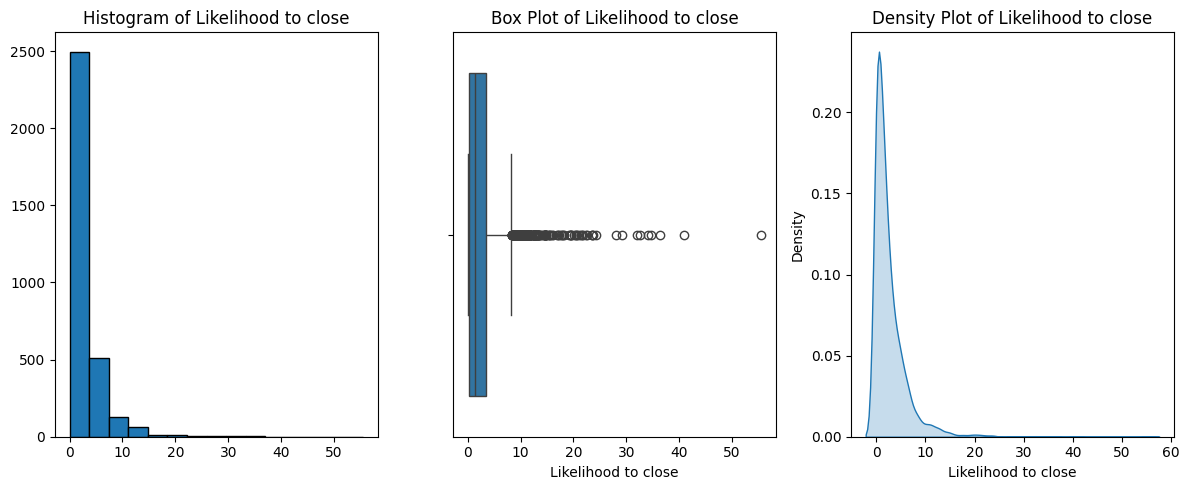

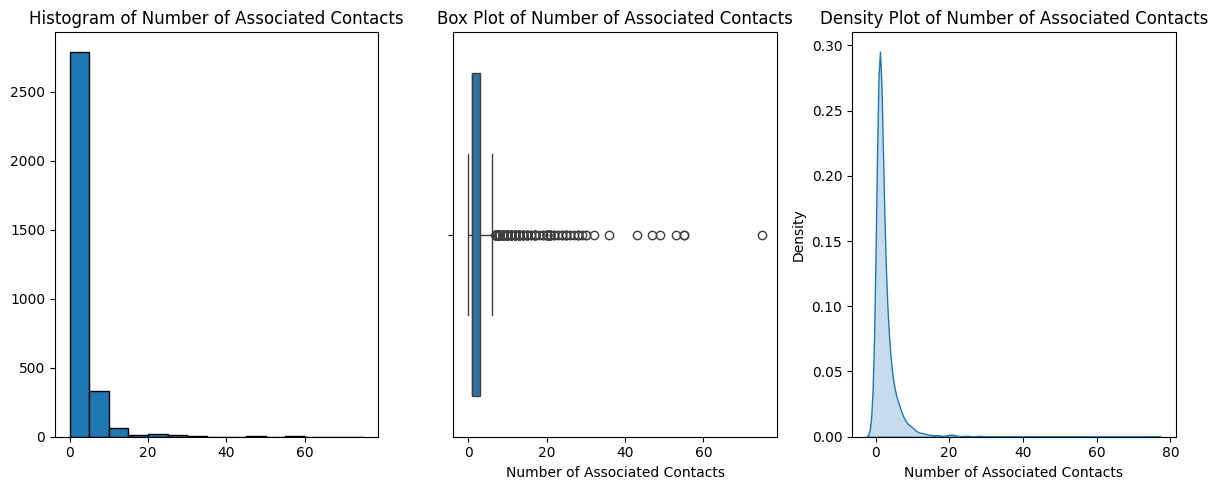

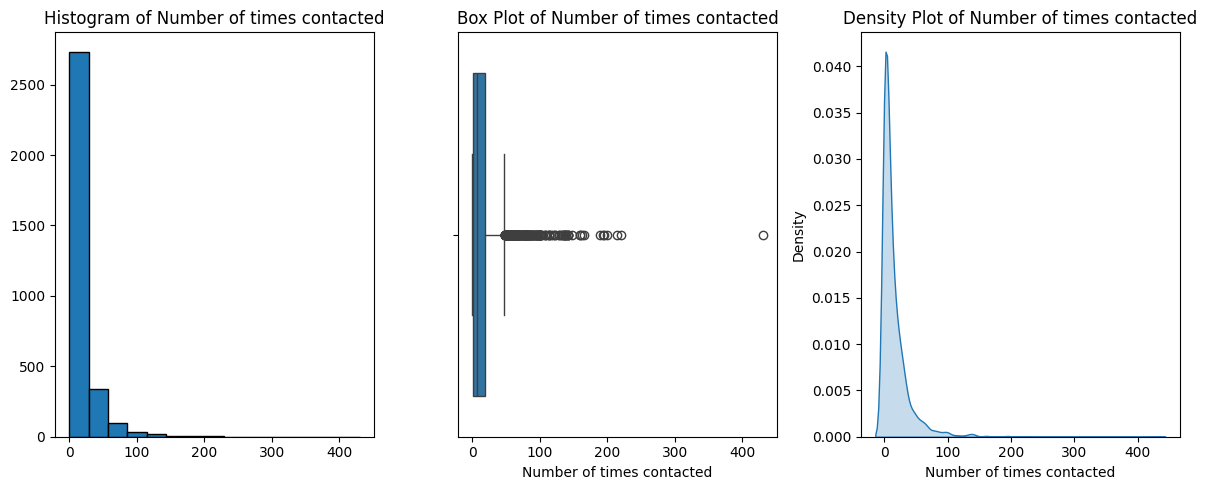

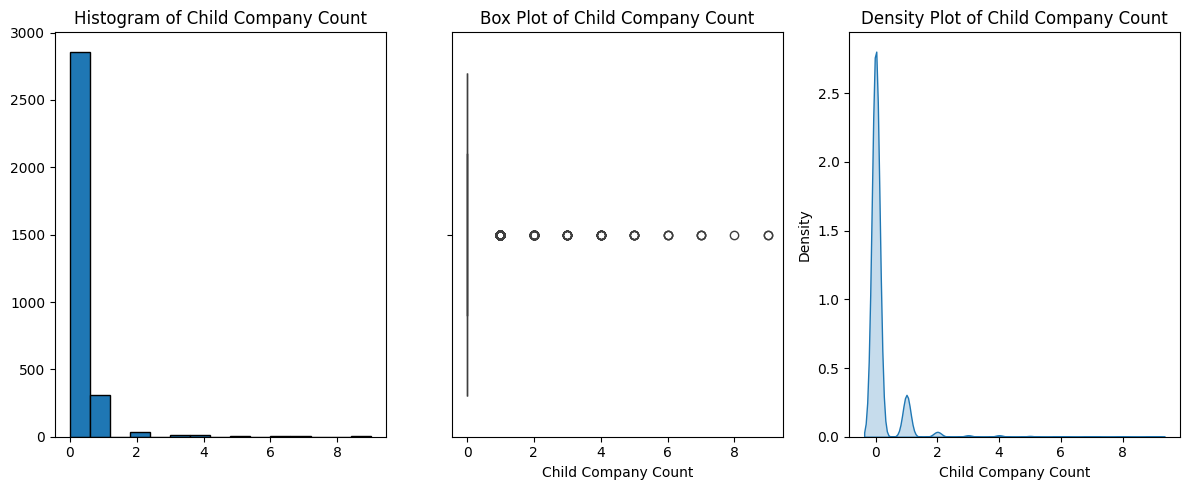

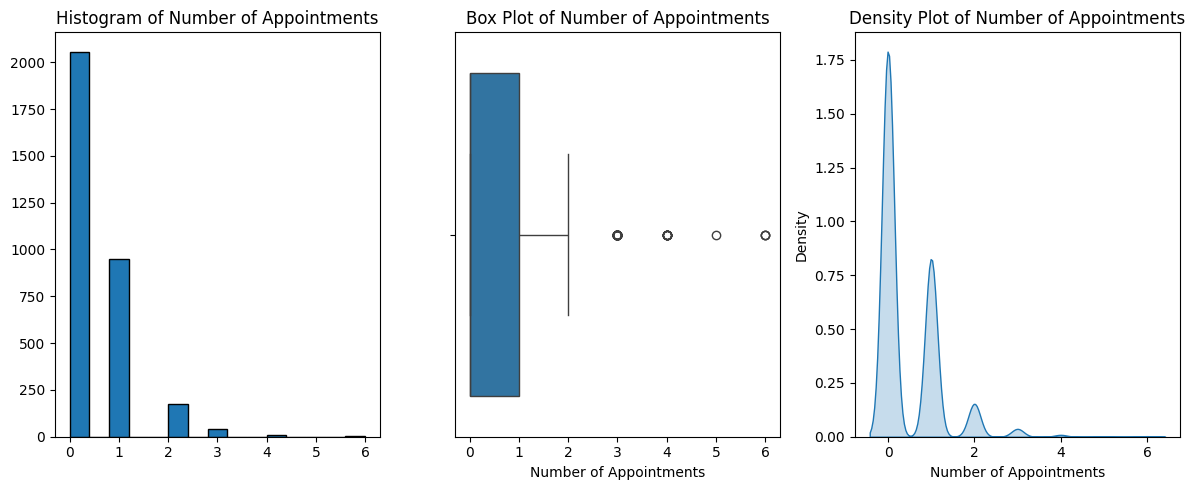

KeyboardInterrupt: 

In [96]:
for col in working_df.select_dtypes(include=['number']).columns:
    if "ID" in col: continue
    plt.figure(figsize=(12, 5))
    
    # Histogram
    plt.subplot(1, 3, 1)
    plt.hist(working_df[col].dropna(), bins=15, edgecolor='k')
    plt.title(f"Histogram of {col}")

    # Box Plot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=working_df[col])
    plt.title(f"Box Plot of {col}")

    # Density Plot
    plt.subplot(1, 3, 3)
    sns.kdeplot(working_df[col].dropna(), fill=True)
    plt.title(f"Density Plot of {col}")
    
    plt.tight_layout()
    plt.show()

*Informal Note for StaffAny - if Record ID is added sequentially, StaffAny's growth trajectory definitely seems to be slowing down, as they are acquiring fewer IDs towards the tail end of the distribution. FYI only*

##### Normality Tests

In [ ]:
normality_results = {}

for col in working_df.select_dtypes(include=["number"]).columns:
    if "ID" in col: continue
    data = working_df[col].dropna()
    
    # Shapiro-Wilk Test
    shapiro_test = shapiro(data)
    # Kolmogorov-Smirnov Test
    ks_test = normaltest(data)
    # Anderson-Darling Test
    anderson_test = anderson(data)
    
    normality_results[col] = {
        'Shapiro-Wilk p-value': shapiro_test.pvalue,
        'Kolmogorov-Smirnov p-value': ks_test.pvalue,
        'Anderson-Darling statistic': anderson_test.statistic
    }

# Create a DataFrame from the normality_results dictionary
normality_df = pd.DataFrame.from_dict(normality_results, orient='index')
# Rename columns for clarity
normality_df.columns = ['Shapiro-Wilk p-value', 'Kolmogorov-Smirnov p-value', 'Anderson-Darling Statistic']
normality_df

##### Outlier Detection

In [ ]:
outliers = {}

for col in working_df.select_dtypes(include=np.number).columns:
    if "ID" in col: continue
    data = working_df[col].dropna()
    
    # IQR Method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    iqr_outliers = data[(data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)]
    
    # Z-Score Method
    z_scores = zscore(data)
    z_outliers = data[np.abs(z_scores) > 3]
    
    outliers[col] = {
        'IQR Outliers Count': iqr_outliers.count(),
        'Z-Score Outliers Count': z_outliers.count()
    }

# Create a DataFrame from the outliers dictionary
outliers_df = pd.DataFrame.from_dict(outliers, orient='index')
# Rename columns for clarity
outliers_df.columns = ['IQR Outliers', 'Z-Score Outliers']
outliers_df

##### Interpretation of Univariate Test for Numerical Data

**General Interpretation of p-values and Statistics**:

- **Shapiro-Wilk Test** and **Kolmogorov-Smirnov Test :** a low p-value (typically below 0.05) suggests that the data **does not follow a normal distribution**
- **Anderson-Darling Statistic :** measures how far the data deviates from a normal distribution. Higher values indicate a stronger deviation from normality
- **IQR Method :** considers values outside the range $[Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}]$ as outliers. It is robust to skewness but sensitive to data spread, often detecting outliers in highly skewed data.
- **Z-Score Method :** method flags values that are more than 3 standard deviations from the mean as outliers. It is more suitable for normally distributed data but can still highlight extreme values in other distributions.

| Column | Shapiro-Wilk p-value | Kolmogorov-Smirnov p-value | Anderson-Darling Statistic | IQR Outliers Count | Z-Score Outliers Count | Interpretation |
|----------------------------|----------------------|----------------------------|----------------------------|---------------------|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Likelihood to Close** | 5.60e-63 | 0.0 | 253.72 | 181 | 55 | Significant deviation from normality; right-skewed distribution with numerous outliers. The majority of values are near zero, with a few high values creating a long tail. Transformation (e.g., log or square root) could help normalize the distribution for analytical models. |
| **Number of Associated Contacts** | 9.69e-72 | 0.0 | 460.90 | 241 | 53 | Strong non-normality; right-skewed distribution with many values near zero and some high values. Numerous outliers detected, especially with the IQR method, indicating variability in contact counts. Transformation may help reduce skewness for analysis. |
| **Number of Times Contacted** | 5.22e-65 | 0.0 | 312.14 | 229 | 67 | Strong non-normality; right-skewed distribution with a peak near zero and a few high values. Large number of outliers detected, suggesting variability in contact frequency. Transformation or outlier treatment might improve the distribution. |
| **Child Company Count** | 3.29e-77 | 0.0 | 887.10 | 380 | 37 | Highly non-normal distribution with significant right skewness. A large count of outliers detected, indicating high variability in child company counts. Transformation may help normalize this feature. |
| **Number of Appointments** | 5.09e-63 | 6.78e-305 | 448.43 | 55 | 55 | Right-skewed distribution with moderate outliers. Most values cluster near zero, with a few high values creating a tail. Consider transformation or outlier treatment for better analysis. |
| **Appointments Strength** | 1.85e-64 | 0.0 | 598.14 | 0 | 0 | Mostly consistent distribution with minimal outliers. Values cluster near zero and 1, suggesting two primary categories. This may be better treated as a categorical measure rather than a continuous one. |
| **Associated Note Count** | 2.10e-59 | 0.0 | 278.35 | 176 | 73 | Strong non-normality with high right skewness and numerous outliers. Most values are near zero, with some high values. May benefit from transformation or capping of extreme values. |
| **Associated Note Strength** | 2.10e-59 | 0.0 | 278.35 | 176 | 73 | Similar to Associated Note Count, this variable is right-skewed with many outliers. Primarily clustered near zero. Transformation might help normalize the distribution. |
| **Weighted Associated Note Strength** | 9.69e-72 | 0.0 | 460.90 | 241 | 53 | Strong non-normality and right skewness, with a large count of outliers. Could benefit from transformation or scaling to reduce skewness and improve distribution. |
| **Associated Contacts Strength** | 2.10e-59 | 0.0 | 278.35 | 176 | 73 | Right-skewed distribution with many outliers. Most values are clustered near zero. Transformation may help reduce the skewness. |
| **Billing Entities Count** | 2.41e-78 | 0.0 | 958.82 | 299 | 34 | Highly skewed and non-normal distribution with substantial outliers. This feature has a high variability, and transformation could help in normalizing it. |
| **Time Known** | 7.33e-39 | 0.0 | 99.09 | 0 | 0 | Stable distribution with minimal skewness and no outliers, suggesting consistency in the data. Suitable for analysis without transformation. |
| **Time Index** | 7.33e-39 | 0.0 | 99.09 | 0 | 0 | Similar to Time Known, this feature has a stable distribution with no outliers. Suitable for analysis without transformation. |
| **Weighted Time Index** | 7.33e-39 | 0.0 | 99.09 | 0 | 0 | Stable distribution with minimal skewness and no outliers, making it appropriate for direct analysis. |

##### Conclusions

- **Transform Data**: Given the strong right-skewed distributions in several variables, applying log or square root transformations could help in normalizing the data for models that assume normality. However, consider this transformation on variables with a meaningful zero point and without many zero values (since log transformations of zero are undefined).
- **Treat Outliers**: The high number of outliers identified by both IQR and Z-score methods suggests that some variables have significant variability. Depending on the analysis goals, you could:
  - **Cap extreme values** to limit the impact of outliers without discarding valuable data.
  - **Apply robust scaling** to reduce the influence of outliers while preserving the overall distribution.
  - **Segment the data**: If outliers represent meaningful sub-groups (e.g., high-value customers), analyze these groups separately to avoid skewing overall results.
- **Consider Non-Parametric Methods**: The significant deviation from normality in most variables indicates that non-parametric methods (such as rank-based analyses or tree-based models) may yield more reliable results than parametric approaches that assume normality.
- **Explore Feature Engineering**: Given that some variables like "Appointments Strength" and "Associated Note Strength" are highly clustered around specific values, consider:
  - **Discretizing these variables** if they provide limited information as continuous values, especially if they represent inherent categories.
  - **Combining features** to capture interactions or patterns that may not be apparent in individual variables.
- **Further Investigation of Outliers**: Analyze outliers to identify potential patterns, distinct behaviors, or possible data entry errors. For instance:
  - **Cluster analysis on outliers** may reveal whether they represent specific customer segments with unique behaviors.
  - **Inspect outlier data points individually** to see if they reflect meaningful insights (e.g., high engagement customers, large accounts) or if they are due to anomalies.
- **Potential for Segmentation**: Given the variability and outlier behavior in customer engagement metrics, segmentation might uncover insights into different types of customers. For example, high engagement vs. low engagement customers could benefit from different strategies.
- **Assess Model Robustness**: When using machine learning models, consider models that are robust to non-normality and outliers, such as decision trees or ensemble methods, which can handle skewed distributions more effectively than linear models.

#### Univariate Analysis for Object & Category Fields

##### Descriptive Statistics

In [ ]:
working_df.select_dtypes(include=['object']).describe()

##### Descriptive Statistics

For categories

In [ ]:
working_df.select_dtypes(include=['category']).describe()

In [ ]:
# Identify categorical columns (object or category types)
categorical_columns = working_df.select_dtypes(include=['object', 'category']).columns

# Exclude specific columns from the analysis
categorical_columns = categorical_columns.drop(['Associated Note', 'Associated Contact'])

# Separate columns with lists from those with single categories
list_columns = []
single_category_columns = []

for col in categorical_columns:
    # Check if the column contains any list entries
    if working_df[col].apply(lambda x: isinstance(x, list)).any():
        list_columns.append(col)  # This column has lists (multiple categories)
    else:
        single_category_columns.append(col)  # This column has single categorical values

#### Frequency Distribution

In [ ]:
for col in single_category_columns:
    # Calculate the frequency distribution
    freq = working_df[col].value_counts()
    perc = working_df[col].value_counts(normalize=True) * 100  # Percentage distribution
    
    # Display frequency table
    print(f"Univariate Analysis for '{col}'")
    print("Frequency Distribution:\n", freq)
    print("\nPercentage Distribution:\n", perc)
    print("=" * 50)
    
    # Plot frequency distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=freq.index, y=freq.values, palette='viridis')
    plt.title(f"Frequency Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Univariate analysis on columns with multiple categories (list columns)
for col in list_columns:
    print(f"\nUnivariate Analysis for Multi-Category Column '{col}'")

    # Explode the column to transform each list element into its own row
    exploded_col = working_df.explode(col)
    
    # Drop any NaNs resulting from exploding (in case some rows had empty lists)
    exploded_col = exploded_col.dropna(subset=[col])
    
    # Calculate the frequency distribution for the exploded data
    freq = exploded_col[col].value_counts()
    perc = exploded_col[col].value_counts(normalize=True) * 100  # Percentage distribution

    # Display frequency table
    print("Frequency Distribution:\n", freq)
    print("\nPercentage Distribution:\n", perc)
    print("=" * 50)
    
    # Plot frequency distribution for exploded data
    plt.figure(figsize=(10, 6))
    sns.barplot(x=freq.index, y=freq.values, palette='viridis')
    plt.title(f"Frequency Distribution of '{col}' (Exploded)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.show()

#### Chi-Sqaure Goodness of Fit Test

In [ ]:
# Chi-Square test on columns with single categories
print("Chi-Square Test for Single-Category Columns")
for col in single_category_columns:
    # Calculate observed frequencies
    observed_freq = working_df[col].value_counts()
    
    # Set up expected frequencies for a uniform distribution
    num_categories = len(observed_freq)
    total_count = observed_freq.sum()
    expected_freq = [total_count / num_categories] * num_categories
    
    # Perform Chi-Square Goodness of Fit Test
    chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)
    
    # Display the results
    print(f"\nChi-Square Test for '{col}'")
    print("Chi-Square Statistic:", chi2_stat)
    print("p-value:", p_value)
    if p_value < 0.05:
        print("Conclusion: Reject the null hypothesis - the distribution is not uniform.")
    else:
        print("Conclusion: Fail to reject the null hypothesis - the distribution could be uniform.")
    print("=" * 50)

# Chi-Square test on columns with multiple categories (list columns)
print("\nChi-Square Test for Multi-Category (List) Columns")
for col in list_columns:
    # Explode the column to transform each list element into its own row
    exploded_col = working_df.explode(col)
    
    # Drop any NaNs resulting from exploding (in case some rows had empty lists)
    exploded_col = exploded_col.dropna(subset=[col])
    
    # Calculate observed frequencies for the exploded data
    observed_freq = exploded_col[col].value_counts()
    
    # Set up expected frequencies for a uniform distribution
    num_categories = len(observed_freq)
    total_count = observed_freq.sum()
    expected_freq = [total_count / num_categories] * num_categories
    
    # Perform Chi-Square Goodness of Fit Test
    chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)
    
    # Display the results
    print(f"\nChi-Square Test for exploded '{col}'")
    print("Chi-Square Statistic:", chi2_stat)
    print("p-value:", p_value)
    if p_value < 0.05:
        print("Conclusion: Reject the null hypothesis - the distribution is not uniform.")
    else:
        print("Conclusion: Fail to reject the null hypothesis - the distribution could be uniform.")
    print("=" * 50)

##### Interpretation of Univariate Test for Categorical Columns

| Column| Top Categories (Frequency %)|Chi-Square Statistic|p-value|Conclusion|
|----------------------------|-------------------------------------------------------------------|-----------------------|---------|----------------------------------------------------------------------------------------------------------|
|**Industry (StaffAny Official)**|- Food & Beverages (51.93%)  <br> - Unknown (20.56%) <br> - Services (8.61%)|15645.01| 0.0|The distribution is highly skewed, dominated by Food & Beverages. Chi-Square test indicates non-uniformity.|
|**Year**| - 2019 (28.00%) <br> - 2023 (21.77%) <br> - 2022 (21.43%)| 2080.95| 0.0|Entries are skewed towards recent years, especially 2019-2023. The distribution is non-uniform.|
|**Campaign**| - 2024_PR_2 (94.22%) <br> - 2023_EE_3 (3.01%)| 3316.08| 0.0|Heavily dominated by 2024_PR_2. Chi-Square test indicates significant non-uniformity.|
|**Ideal Customer Profile**|- ICP1 (31.60%) <br> - ICP3 (18.24%) <br> - ICP4 (14.12%)| 2089.62|0.0|The distribution is skewed towards certain profiles, especially ICP1. Chi-Square test confirms non-uniformity. |

##### Conclusions
- **Industry (StaffAny Official)**: The data is heavily skewed towards the "Food & Beverages" industry, indicating a high concentration in this sector. The presence of a large "Unknown" category may suggest incomplete or generalized data entry practices.
- **Year**: The distribution shows a higher number of entries from recent years, particularly 2019-2023, which could reflect business growth or data expansion over time.
- **Campaign**: The "2024_PR_2" campaign overwhelmingly dominates, suggesting that most recorded entries are associated with this campaign, potentially due to recent marketing efforts or data entry practices.
- **Ideal Customer Profile**: Certain customer profiles, like ICP1 and ICP3, are more prevalent, indicating a primary target demographic. Lower counts for partner profiles suggest fewer strategic partnerships.

Adjustments or further data collection may be necessary to balance representation if aiming for uniform distribution.

#### Univariate Analysis for Boolean Fields

##### Descriptive Statistics

For boolean

In [ ]:
working_df.select_dtypes(include=['bool']).describe()

##### Frequency Distribution

In [ ]:
for col in working_df.select_dtypes(include=['bool']).columns:
    # Calculate frequency distribution
    freq = working_df[col].value_counts()
    perc = working_df[col].value_counts(normalize=True) * 100  # Percentage distribution
    
    # Display frequency table
    print(f"Univariate Analysis for '{col}'")
    print("Frequency Distribution:\n", freq)
    print("\nPercentage Distribution:\n", perc)
    print("=" * 50)
    
    # Plot frequency distribution
    plt.figure(figsize=(6, 4))
    sns.barplot(x=freq.index.astype(str), y=freq.values, palette='viridis')
    plt.title(f"Frequency Distribution of '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

##### Interpretation of Univariate Test for Categorical Columns

 Column|True Count (%)|False Count (%)|Interpretation|
|----------------------|----------------------|-----------------------|-------------------------------------------------------------------------------------------------------------|
|**Is Billing Entity**|299 (9.23%)|2940 (90.77%)| Most entries are not billing entities, indicating a focus on companies without billing relationships.|
|**Is Parent**|3138 (96.88%)|101 (3.12%)|The majority of entries represent parent companies, suggesting that the dataset focuses on higher-level entities rather than subsidiaries.|
|**Has Parent**|101 (3.12%)| 3138 (96.88%)| Few entries have a parent company, indicating that most entities are independent or stand-alone businesses.|
|**Has Appointments**|1171 (36.15%)|2068 (63.85%)| A significant portion of entries do not have appointments, which could indicate a lower level of active engagement.|
|**Is Lacking Note**|1292 (39.89%)|1947 (60.11%)| Most entries are documented with notes, suggesting thorough tracking and record-keeping for the majority of companies.|
|**Is Lacking Contact**|176 (5.43%)|3063 (94.57%)| Very few entries lack contact information, indicating that contact details are generally well-maintained.|
|**Has Churned**|185 (5.71%)|3054 (94.29%)| A low churn rate suggests strong customer retention or that the dataset primarily includes active companies.|

##### Conclusions

- **Is Billing Entity**: Only a small proportion of companies are billing entities, indicating the dataset's focus may be on prospect or potential clients rather than paying customers.
- **Is Parent & Has Parent**: Most entries are independent parent companies, with only a small subset having parent organizations, indicating a dataset centered on standalone entities.
- **Has Appointments**: A lower percentage of entries with appointments suggests limited active engagement with some entities, possibly due to early stages in the sales cycle or lower engagement focus.
- **Is Lacking Note**: Most companies are well-documented with notes, showing good record-keeping practices.
- **Is Lacking Contact**: Almost all entries have contact information, suggesting an emphasis on maintaining communication details.
- **Has Churned**: A low churn rate reflects strong customer retention or a focus on active clients, which could be beneficial for understanding long-term engagement.

The boolean column analysis reveals a dataset heavily focused on parent companies without billing relationships or appointments. It reflects thorough record-keeping and low churn, which indicates a stable customer base with strong retention. This focus on standalone entities with available contact information may guide strategic engagement and account management efforts.

#### 5. Data Transformations

### Step 4. Bi-variate/Multivariate Analysis

In [ ]:
# Correlation matrix for numerical variables including the target variable
correlation_matrix = final_df[numerical_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical data for first time clients")
plt.show()

# Correlation matrix for numerical variables including the target variable
correlation_matrix = first_time_be_df[numerical_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical data for first time clients")
plt.show()

# Correlation matrix for numerical variables including the target variable
correlation_matrix = repeat_be_df[numerical_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical data for repeat clients")
plt.show()

# Correlation matrix for numerical variables including the target variable
correlation_matrix = non_be_df[numerical_columns].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical data for non-clients")
plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Associated Note_count', 'Deal with Primary Company_count'),
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    # Add more pairs as needed
]

# Filter the DataFrame for the current ICP category
for x_col, y_col in pairs_to_plot:
    # Now create scatter plot with regression line using the filtered data
    plt.figure(figsize=(10, 6))
    sns.jointplot(
        data=first_time_be_df,
        x=x_col,
        y=y_col,
        kind="kde",
    )
    
    plt.suptitle(f'Density Plot of {x_col} and {y_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    plt.subplots_adjust(top=0.95)  # Reduce plot to make room for title
    
    # Show the plot
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Associated Note_count', 'Deal with Primary Company_count'),
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    # Add more pairs as needed
]

# Filter the DataFrame for the current ICP category
for x_col, y_col in pairs_to_plot:
    # Now create scatter plot with regression line using the filtered data
    plt.figure(figsize=(10, 6))
    sns.jointplot(
        data=first_time_be_df,
        x=x_col,
        y=y_col,
        kind="kde",
    )
    
    plt.suptitle(f'Density Plot of {x_col} and {y_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    plt.subplots_adjust(top=0.95)  # Reduce plot to make room for title
    
    # Show the plot
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Associated Note_count', 'Deal with Primary Company_count'),
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    # Add more pairs as needed
]

# Filter the DataFrame for the current ICP category
for x_col, y_col in pairs_to_plot:
    # Now create scatter plot with regression line using the filtered data
    plt.figure(figsize=(10, 6))
    sns.jointplot(
        data=be_df,
        x=x_col,
        y=y_col,
        kind="kde",
    )
    
    plt.suptitle(f'Density Plot of {x_col} and {y_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    plt.subplots_adjust(top=0.95)  # Reduce plot to make room for title
    
    # Show the plot
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Associated Note_count', 'Deal with Primary Company_count'),
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    ('Associated Note_count', 'First_Sales_Cycle_Duration'),
    ('Number of times contacted', 'First_Sales_Cycle_Duration'),
    ('Number of Associated Contacts', 'First_Sales_Cycle_Duration'),
    ('Associated Note_count', 'BE_count'),
    ('Number of Associated Contacts', 'BE_count'),
    ('Number of times contacted', 'BE_count'),
    # Add more pairs as needed
]

# Filter the DataFrame for the current ICP category
for x_col, y_col in pairs_to_plot:
    # Now create scatter plot with regression line using the filtered data
    plt.figure(figsize=(10, 6))
    sns.jointplot(
        data=final_df,
        x=x_col,
        y=y_col,
        kind="kde",
    )
    
    plt.suptitle(f'Density Plot of {x_col} and {y_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    plt.subplots_adjust(top=0.95)  # Reduce plot to make room for title
    
    # Show the plot
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    # Add more pairs as needed
]

# Iterate through each ICP category and each pair to plot
for x_col, y_col in pairs_to_plot:  
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.pointplot(x=x_col, y=y_col, data=first_time_be_df)
    plt.title(f'Scatter Plot of {x_col} vs {y_col} for first time clients')
    plt.xlabel(x_col, color='red')
    plt.ylabel(y_col)

    # Optionally, add a regression line
    sns.regplot(x=x_col, y=y_col, data=first_time_be_df, scatter=False, color='red')

    # Show the plot
    plt.xlim(0, 30)
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Number of Associated Contacts', 'Deal with Primary Company_count'),
    ('Number of times contacted', 'Deal with Primary Company_count'),
    # Add more pairs as needed
]

# Iterate through each ICP category and each pair to plot
for x_col, y_col in pairs_to_plot:  
    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    sns.pointplot(x=x_col, y=y_col, data=first_time_be_df)
    plt.title(f'Scatter Plot of {x_col} vs {y_col} for first time clients')
    plt.xlabel(x_col, color='red')
    plt.ylabel(y_col)

    # Optionally, add a regression line
    sns.regplot(x=x_col, y=y_col, data=first_time_be_df, scatter=True, color='red')

    # Show the plot
    plt.show()

In [ ]:
# Select pairs of variables with strong correlation
pairs_to_plot = [
    ('Number of Associated Contacts', 'First_Sales_Cycle_Duration'),
    # Add more pairs as needed
]

# Iterate through each ICP category and each pair to plot
for category in icp_columns:
    for x_col, y_col in pairs_to_plot:
        # Filter the DataFrame for the current ICP category
        filtered_df = non_be_df[non_be_df[category] == 1]
        filtered_df
        
        # Create the scatter plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=x_col, y=y_col, data=filtered_df)
        plt.title(f'Scatter Plot of {x_col} vs {y_col} for {category}')
        plt.xlabel(x_col, color='red')
        plt.ylabel(y_col)

        # Optionally, add a regression line
        sns.regplot(x=x_col, y=y_col, data=filtered_df, scatter=False, color='red')

        # Show the plot
        plt.show()

In [ ]:
# Analyze relationships between categorical variables and the target variable using count plots
fig, axes = plt.subplots(len(categorical_columns) - 1, 1, figsize=(8, 24))  # Exclude target variable from analysis
for i, col in enumerate(categorical_columns):  # Exclude 'Lung Cancer Occurrence'
    sns.countplot(x=col, hue='BE_Indicator', data=be_df, ax=axes[i])
    axes[i].set_title(f'{col} vs BillingEntity_Indicator')
    axes[i].legend(title='BE Indicator', loc='upper right')

plt.tight_layout()

#### Correlation Analysis:
- The correlation matrix primarily focused on numerical variables shows limited correlation between these variables and the lung cancer occurrence.
- This indicates that no single numerical factor strongly predicts lung cancer occurrence on its own
- THis also highlights the complexity of the disease and the potential need for a multifactorial approach to prediction.

#### Categorical Variables Analysis:
- **Gender**: There appears to be a difference in lung cancer occurrence between genders, suggesting that gender may play a role in lung cancer risk.
- **COPD History**: Patients with a history of COPD show a higher occurrence of lung cancer, indicating a potential link between COPD and lung cancer risk.
- **Genetic Markers**: The presence of genetic markers seems to correlate with a higher incidence of lung cancer, supporting the role of genetics in lung cancer risk.
- **Air Pollution Exposure**: Higher levels of air pollution exposure are associated with a greater occurrence of lung cancer, highlighting environmental factors in lung cancer risk.
- **Taken Bronchodilators**: The use of bronchodilators is more common among patients with lung cancer, which may reflect underlying respiratory conditions rather than a direct causative relationship.
- **Frequency of Tiredness**: There's a visible trend where increased tiredness frequency is associated with higher lung cancer occurrence, possibly indicating symptom severity or general health status.
- **Dominant Hand**: No clear relationship is observed between the dominant hand and lung cancer occurrence, suggesting that handedness is not a relevant factor in lung cancer risk.

### Conclusions from Bivariate/Multivariate Analysis:
- The analysis reveals that lung cancer occurrence is associated with several factors, including gender, COPD history, genetic markers, air pollution exposure, and potentially the severity of symptoms like tiredness.
- The relationships between these variables and lung cancer occurrence suggest that a combination of demographic, genetic, environmental, and health-related factors contribute to lung cancer risk.
- The lack of strong correlations among numerical variables and lung cancer occurrence emphasizes the need for a comprehensive approach that includes both numerical and categorical data in predicting lung cancer risk.
- The lack of strong correlation between dominant hand and lung cancer occurrence suggests that theis categorical variable can be removed 


### Step 5: Feature Engineering and Selection for Task 2

Based on the insights from the previous analyses, we can identify potential features that might improve the predictability of lung cancer occurrence and select the most relevant variables for modeling. Here's a proposed approach:

#### Feature Engineering:
- **Smoking Duration**: Calculate the duration of smoking as `Stop Smoking Year - Start Smoking Year`. This new feature could capture the impact of long-term smoking on lung cancer risk.
- **Weight Change**: Compute the weight change as `Current Weight - Last Weight`. This feature might indicate health changes that are relevant to lung cancer risk.
- **Age at Start Smoking**: Considering the age when the patient started smoking might provide insights into vulnerability due to early exposure.

#### Feature Selection:
- **Numerical Variables**: Include the newly engineered features (Smoking Duration, Weight Change, Age at Start Smoking) along with Age, as these directly relate to personal health status and behaviors that could influence lung cancer risk.
- **Categorical Variables**: Retain variables that showed significant associations with lung cancer occurrence in the bivariate analysis, including Gender, COPD History, Genetic Markers, and Air Pollution Exposure. The Frequency of Tiredness might also be included as it could reflect overall health status.


In [ ]:
# Feature Engineering
df_cleaned['Smoking Duration'] = df_cleaned['Stop Smoking'] - df_cleaned['Start Smoking']
df_cleaned['Weight Change'] = df_cleaned['Current Weight'] - df_cleaned['Last Weight']

# Assuming age at start smoking is 'Age' - ('Current Year' - 'Start Smoking Year')
# Using a fixed current year as 2024 for simplicity, since data analysis is being conducted in 2024
current_year = 2024
df_cleaned['Age at Start Smoking'] = df_cleaned['Age'] - (current_year - df_cleaned['Start Smoking'])

# Update the list of numerical columns to include the new features
numerical_columns_updated = ['Age', 'Smoking Duration', 'Weight Change', 'Age at Start Smoking']

# Selected categorical columns based on analysis
selected_categorical_columns = ['Gender', 'COPD History', 'Genetic Markers', 'Air Pollution Exposure', 'Frequency of Tiredness']

# Final dataset for modeling
final_features = numerical_columns_updated + selected_categorical_columns + ['Lung Cancer Occurrence']
df_modeling = df_cleaned[final_features]

# Display the first few rows of the updated DataFrame for modeling
df_modeling.head()

### New Features Created:

- **Smoking Duration**: Calculated as the difference between the stop and start years of smoking, providing a measure of the exposure duration to smoking.
- **Weight Change**: Represents the difference between the current and last recorded weights, potentially indicating health changes.
- **Age at Start Smoking**: Estimated age when the patient started smoking, offering insights into early exposure risks.

### Final Set of Variables:

- **Numerical Variables**: Age, Smoking Duration, Weight Change, and Age at Start Smoking.
- **Categorical Variables**: Gender, COPD History, Genetic Markers, Air Pollution Exposure, and Frequency of Tiredness.
- **Target Variable**: Lung Cancer Occurrence.

This refined dataset integrates both individual health-related behaviors and genetic/environmental factors, aiming to enhance the predictive accuracy for lung cancer occurrence. 
The inclusion of engineered features is expected to provide additional insights into the multifactorial nature of lung cancer risk.

## Conclusion

Throughout this Exploratory Data Analysis (EDA), I have navigated through the various stages necessary to understand and prepare the dataset for further analysis and modeling, specifically focusing on the risk factors associated with lung cancer occurrence. Here's a summary of my key findings and actions:

1. **Data Loading and Initial Inspection**: I commenced by loading the dataset and conducting an initial inspection, identifying the structure, data types, and potential issues such as missing values and outliers.

2. **Data Cleaning**: This phase involved converting data types for better analysis, handling missing values, and addressing outliers, particularly in the `Age` attribute, to ensure data integrity and reliability.

3. **Univariate Analysis**: I analyzed individual variables to understand their distributions and identify patterns. This revealed insights into patient demographics, health behaviors, and clinical attributes, highlighting significant variances and outliers in some key variables.

4. **Bivariate/Multivariate Analysis**: The relationships between variables and lung cancer occurrence were explored, indicating that factors such as gender, COPD history, genetic markers, and air pollution exposure are associated with lung cancer risks. This phase underscored the multifactorial nature of lung cancer, suggesting the need for a comprehensive approach to prediction.

5. **Feature Engineering and Selection**: Based on the insights gained, new features were created to capture aspects like smoking duration and weight change, which are potentially indicative of lung cancer risk. A subset of variables was selected for modeling, balancing between numerical and categorical data to enhance the predictive model's accuracy.